# Описание данных

**Файл с данными: events.csv**

События пользователей за 3 месяца, которые попали на сайт в первый месяц наблюдения.
Используется трекинг событий - https://snowplowanalytics.com/. Подробности схемы событий можно посмотреть в документации (возможны расхождения в версиях трекера).

Обратите внимание на атрибут event_name - разные типы событий (см. документацию)


Краткое описание:

**domain_userid** - хеш, который трекер генерирует и записывает к куки  
**user_id** - id пользователя после регистрации на сайте  
больше подробностей: https://docs.snowplowanalytics.com/docs/collecting-data/collecting-from-own-applications/java-tracker/tracking-specific-client-side-properties/

refr_\*, mkt_\*  
подробности по этим и другим атрибутам см. в документации - https://docs.snowplowanalytics.com/docs/understanding-your-pipeline/canonical-event/

In [1]:
import pandas as pd
import datetime
from datetime import date, datetime, timedelta
import datetime as dt
import numpy as np
import calendar
import sidetable
import warnings
import math
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go 

In [2]:
warnings.filterwarnings("ignore")

In [3]:
# import dask.dataframe as dd

In [4]:
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)

In [5]:
path = 'C:/Users/Dmikuznetsov/Mvideo/Практикум/TV/events'

In [150]:
# ddf = dd.read_csv(path + '/' + 'events.csv', dtype={'product_bill': 'object','mkt_content': 'object' },low_memory=False)

In [151]:
%%time
# df_1 = ddf.compute()

Wall time: 0 ns


In [152]:
%%time
df_1 = pd.read_csv(path + '/' + 'events.csv')

Wall time: 8min 55s


In [153]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57198716 entries, 0 to 57198715
Data columns (total 21 columns):
 #   Column            Dtype  
---  ------            -----  
 0   platform          object 
 1   collector_tstamp  object 
 2   event_name        object 
 3   user_id           float64
 4   domain_userid     object 
 5   page_urlpath      object 
 6   page_urlquery     object 
 7   refr_urlhost      object 
 8   refr_urlpath      object 
 9   refr_medium       object 
 10  refr_source       object 
 11  mkt_medium        object 
 12  mkt_source        object 
 13  mkt_term          object 
 14  mkt_content       object 
 15  mkt_campaign      object 
 16  pd_feature_id     object 
 17  pd_dialog_action  object 
 18  trial_product     object 
 19  trial_action      object 
 20  product_bill      object 
dtypes: float64(1), object(20)
memory usage: 8.9+ GB


# Задание 1 - UID

*проставить user_id "в историю"*

**user_id - domain_userid - uid**

В данных представлены события по новым пользователям, в том числе по которым не было регистрации.

user_id заполняется только после регистрации и только по залогиненным пользователям. 

Создать новый атрибут - uid. 
- uid = domain_userid, если по domain_userid не было зарегистрировано/связано user_id
- uid = user_id, если в датасете есть связи user_id<->domain_userid


In [154]:
df_1.domain_userid.isna().sum()

0

нет пропущенных значений

In [155]:
df_1.head()

,platform,collector_tstamp,event_name,user_id,domain_userid,page_urlpath,page_urlquery,refr_urlhost,refr_urlpath,refr_medium,refr_source,mkt_medium,mkt_source,mkt_term,mkt_content,mkt_campaign,pd_feature_id,pd_dialog_action,trial_product,trial_action,product_bill
0,web,2020-06-01 00:00:39,page_view,NaN,d55a7c60-4c7e-4a21-b737-51fd4b6b455d,/symbols/GBPAUD/,NaN,www.google.co.jp,/,search,Google,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,web,2020-06-01 00:00:44,page_view,NaN,e050d9f0-a128-4c00-9c82-afafbdf2d693,/,NaN,www.google.com,/,search,Google,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,web,2020-06-01 00:01:08,page_view,NaN,8ed191b8-01e0-4d26-96f9-56d1ddb49331,/symbols/MOEX-BR1%21/ideas/,NaN,yandex.ru,/,search,Yandex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,web,2020-06-01 00:01:20,page_view,NaN,6250b4fb-769c-46e3-aee4-563d63bbe63f,/ideas/tradeview/,NaN,www.google.com,/,search,Google,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,web,2020-06-01 00:01:23,page_view,NaN,c7380468-023a-4bf5-9979-0b336944a7ba,/chart/,symbol=FX:GBPUSD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [156]:
# привожу к временному типу
df_1['collector_tstamp'] =  pd.to_datetime(df_1['collector_tstamp'], format='%Y-%m-%d %H:%M:%S')

In [158]:
# df_1.to_csv('df_1.csv', index = False)

In [8]:
%%time
# df_1 = pd.read_csv('df_1.csv')

Wall time: 8min 28s


In [9]:
# сортирую по 'domain_userid' и по времени
df_1 = df_1.sort_values(by = ['domain_userid','collector_tstamp'], ascending=True)

In [10]:
df_1

,platform,collector_tstamp,event_name,user_id,domain_userid,page_urlpath,page_urlquery,refr_urlhost,refr_urlpath,refr_medium,refr_source,mkt_medium,mkt_source,mkt_term,mkt_content,mkt_campaign,pd_feature_id,pd_dialog_action,trial_product,trial_action,product_bill
6089418,web,2020-06-09 21:36:44,page_view,NaN,00000064-d28a-48c5-b43b-b27b1d080246,/covid19/,NaN,www.google.com,/,search,Google,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6196002,web,2020-06-09 21:36:56,page_view,NaN,00000064-d28a-48c5-b43b-b27b1d080246,/covid19/,NaN,www.google.com,/,search,Google,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9683889,web,2020-06-14 19:28:23,page_view,NaN,000000c5-18c9-49c3-b670-5a36b5657f82,/markets/stocks-turkey/market-movers-most-vola...,NaN,www.google.com.tr,/,search,Google,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9963612,web,2020-06-14 19:28:42,page_view,NaN,000000c5-18c9-49c3-b670-5a36b5657f82,/markets/stocks-turkey/market-movers-active/,NaN,NaN,/markets/stocks-turkey/market-movers-most-vola...,internal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24852876,web,2020-06-30 20:51:00,page_view,NaN,0000029f-8033-4d03-b317-c4c2ad0efd7b,/symbols/GBPUSD/,utm_campaign=ticker-tape&utm_medium=widget_new...,s.tradingview.com,/,unknown,NaN,widget_new,www.atlanticmarkets.co.uk,NaN,NaN,ticker-tape,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4075010,web,2020-06-07 16:52:13,page_view,4027361.0,ffffff6a-44b6-465f-9eac-46966e50159e,/u/M_Kaay305/,NaN,NaN,/u/Tradingstrategyguides/,internal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3972882,web,2020-06-07 17:00:15,page_view,4027361.0,ffffff6a-44b6-465f-9eac-46966e50159e,/u/Tradingstrategyguides/,NaN,NaN,/,internal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4080241,web,2020-06-07 17:01:10,page_view,4027361.0,ffffff6a-44b6-465f-9eac-46966e50159e,/gopro/,NaN,NaN,/u/Tradingstrategyguides/,internal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3956750,web,2020-06-07 17:01:31,page_view,4027361.0,ffffff6a-44b6-465f-9eac-46966e50159e,/script/0m4UiJRF-fx-pulse-strategy/,NaN,NaN,/u/Tradingstrategyguides/,internal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**т.к. у одного `domain_userid` есть несколько `user_id`  
группирую по `domain_userid` и смотрю первый попавшийся `user_id` и последний**

In [11]:
agg_func_selection = {'user_id': ['first', 'last']}

In [12]:
# группирую по 'domain_userid' и беру первый и последний userid
df_2 = df_1.groupby(['domain_userid']).agg(agg_func_selection)

In [13]:
df_2 = df_2.stb.flatten()

In [14]:
df_2

,domain_userid,user_id_first,user_id_last
0,00000064-d28a-48c5-b43b-b27b1d080246,NaN,NaN
1,000000c5-18c9-49c3-b670-5a36b5657f82,NaN,NaN
2,0000029f-8033-4d03-b317-c4c2ad0efd7b,4703476.0,4703476.0
3,00000787-0193-4b3a-a7ab-a8c04bde3e5b,NaN,NaN
4,000010b1-ebdf-4079-bcc6-31c4fdf34ce6,NaN,NaN
...,...,...,...
3990902,ffffe6b5-fcb2-44c1-8cea-1ed58a898e3f,NaN,NaN
3990903,ffffe957-5168-4da7-9e4c-9631fc5cb15c,NaN,NaN
3990904,ffffeba3-9164-4e0a-93a6-f770707c00f1,NaN,NaN
3990905,fffffb7e-3692-4c07-a4aa-a0d8922e37d1,NaN,NaN


посмотрим примеры

In [15]:
df_2[df_2['domain_userid'] == '8ea88aff-89f8-4f4d-a5a5-6862d7d6adaa']

,domain_userid,user_id_first,user_id_last
2221460,8ea88aff-89f8-4f4d-a5a5-6862d7d6adaa,3822096.0,320873.0


In [16]:
df_1[df_1['domain_userid'] == '8ea88aff-89f8-4f4d-a5a5-6862d7d6adaa']

,platform,collector_tstamp,event_name,user_id,domain_userid,page_urlpath,page_urlquery,refr_urlhost,refr_urlpath,refr_medium,refr_source,mkt_medium,mkt_source,mkt_term,mkt_content,mkt_campaign,pd_feature_id,pd_dialog_action,trial_product,trial_action,product_bill
259870,web,2020-06-01 13:06:37,page_view,NaN,8ea88aff-89f8-4f4d-a5a5-6862d7d6adaa,/,NaN,www.google.com,/,search,Google,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
270449,pc,2020-06-01 13:23:27,user_signup,3822096.0,8ea88aff-89f8-4f4d-a5a5-6862d7d6adaa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
251600,web,2020-06-01 13:44:07,page_view,NaN,8ea88aff-89f8-4f4d-a5a5-6862d7d6adaa,/,NaN,www.google.com,/,search,Google,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5649714,web,2020-06-09 12:10:30,page_view,NaN,8ea88aff-89f8-4f4d-a5a5-6862d7d6adaa,/,NaN,www.google.com,/,search,Google,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5678515,web,2020-06-09 12:42:20,page_view,NaN,8ea88aff-89f8-4f4d-a5a5-6862d7d6adaa,/chart/,symbol=NASDAQ:AAPL,NaN,/,internal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5573806,web,2020-06-09 12:44:41,permission_dialogs,NaN,8ea88aff-89f8-4f4d-a5a5-6862d7d6adaa,/chart/,symbol=NASDAQ:AAPL,NaN,/,internal,NaN,NaN,NaN,NaN,NaN,NaN,pd_1,open,NaN,NaN,NaN
5989428,web,2020-06-09 13:11:30,page_view,NaN,8ea88aff-89f8-4f4d-a5a5-6862d7d6adaa,/,NaN,www.google.com,/,search,Google,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5621243,web,2020-06-09 13:11:35,page_view,NaN,8ea88aff-89f8-4f4d-a5a5-6862d7d6adaa,/chart/,symbol=NASDAQ:AAPL,NaN,/,internal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5693726,pc,2020-06-09 13:25:39,logins,320873.0,8ea88aff-89f8-4f4d-a5a5-6862d7d6adaa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5655300,web,2020-06-09 13:26:51,page_view,320873.0,8ea88aff-89f8-4f4d-a5a5-6862d7d6adaa,/gopro/,NaN,NaN,/chart/,internal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# у одного domain_userid есть несколько user_id
df_2[(df_2['user_id_first'] != df_2['user_id_last']) & (~df_2['user_id_first'].isna())]

,domain_userid,user_id_first,user_id_last
5,00001605-7a6d-44b0-9ab9-10b7548abfc1,4180041.0,4841676.0
53,0000d22a-c3e2-4ef0-8481-144b5e6217da,4235161.0,4235241.0
130,0001fc9e-8056-4327-9829-7affff0e6c25,4503031.0,1114805.0
504,000827ef-78f7-436e-8d32-e645d3bd714f,4844086.0,2892742.0
520,00086422-2a28-4aac-8a0b-a6a7ee54650b,4521840.0,4550913.0
...,...,...,...
3989851,ffeec95a-a465-4a25-b1a8-3f4f2c24b40f,4705680.0,4705740.0
3989924,fff003b6-0e5a-4c64-a8e1-1b629933eb92,4219496.0,3760166.0
3989983,fff10a3d-ccbd-4d11-8465-e4a7bfc8f31b,4618969.0,5349408.0
3990215,fff51fc8-6d63-4189-a1b8-cf063035c4ee,3852363.0,4231826.0


**т.к. у одного `domain_userid` есть несколько `user_id`, то беру `uid` == `user_id_first`    
считаю что это один пользователь присваиваю ему user_id, тот с которого он в первый раз зарегистрировался**

In [18]:
df_2["uid"] = df_2.apply(lambda x: x.domain_userid if math.isnan(x.user_id_first) else x.user_id_first , axis=1)

In [22]:
df_2

,domain_userid,user_id_first,user_id_last,uid
0,00000064-d28a-48c5-b43b-b27b1d080246,NaN,NaN,00000064-d28a-48c5-b43b-b27b1d080246
1,000000c5-18c9-49c3-b670-5a36b5657f82,NaN,NaN,000000c5-18c9-49c3-b670-5a36b5657f82
2,0000029f-8033-4d03-b317-c4c2ad0efd7b,4703476.0,4703476.0,4703476.0
3,00000787-0193-4b3a-a7ab-a8c04bde3e5b,NaN,NaN,00000787-0193-4b3a-a7ab-a8c04bde3e5b
4,000010b1-ebdf-4079-bcc6-31c4fdf34ce6,NaN,NaN,000010b1-ebdf-4079-bcc6-31c4fdf34ce6
...,...,...,...,...
3990902,ffffe6b5-fcb2-44c1-8cea-1ed58a898e3f,NaN,NaN,ffffe6b5-fcb2-44c1-8cea-1ed58a898e3f
3990903,ffffe957-5168-4da7-9e4c-9631fc5cb15c,NaN,NaN,ffffe957-5168-4da7-9e4c-9631fc5cb15c
3990904,ffffeba3-9164-4e0a-93a6-f770707c00f1,NaN,NaN,ffffeba3-9164-4e0a-93a6-f770707c00f1
3990905,fffffb7e-3692-4c07-a4aa-a0d8922e37d1,NaN,NaN,fffffb7e-3692-4c07-a4aa-a0d8922e37d1


In [23]:
df_2.domain_userid.nunique()

3990907

In [24]:
df_2.uid.nunique()

3685524

разное количество , значит `uid` повторяются

# Задание 2 - Мультиюзеры


Никто не запрещает использовать одно устройство нескольким пользователям. 
Но в таких случаях почти невозможно разделить такие случаи, от создания одним пользователем нескольких аккаунтов с целью получения выгоды, например:
- накрутка лайков и другой социальной активности
- неограниченный доступ к триалам (триалы даются на 30 дней один раз)

Для упрощения задачи анализа трафика нужно убрать пользователей с мультиаккаунтами

чтобы лучше понимать трекинг пользователей - ещё раз обратите внимание на https://docs.snowplowanalytics.com/docs/collecting-data/collecting-from-own-applications/java-tracker/tracking-specific-client-side-properties/

Т.е. будут user_id, у которых будет один или несколько одинаковых domain_userid

**Есть `user_id` у которых несколько `domain_userid`  
по условию задачи удаляем таких юзеров** 

In [25]:
df_2[df_2.duplicated(['uid'], keep=False)]

,domain_userid,user_id_first,user_id_last,uid
5,00001605-7a6d-44b0-9ab9-10b7548abfc1,4180041.0,4841676.0,4180041.0
6,00001b18-ae54-4dff-8ce8-ef7d78bdfcc3,4215696.0,4215696.0,4215696.0
52,0000d1be-21c0-4cbc-93d0-87329bc336a7,4343619.0,4343619.0,4343619.0
85,000167cf-7983-40dc-bbfb-2e97e341b44d,3871553.0,3871553.0,3871553.0
87,000169a9-8de1-4f37-ab25-06f565bac30d,4844478.0,4844478.0,4844478.0
...,...,...,...,...
3990879,ffff9368-0051-49d5-91d0-55f70791e776,4494893.0,4494893.0,4494893.0
3990884,ffffad7f-f344-479c-8cc2-6e8d6ea92f5b,4478472.0,4478472.0,4478472.0
3990893,ffffd80b-1303-464f-8ad5-7989ec1dca86,5088560.0,5088560.0,5088560.0
3990895,ffffda1b-7066-41a8-8817-4d5f6ea10d81,4023013.0,4023013.0,4023013.0


In [26]:
#пример
df_2[df_2['uid'] == 3884347.0]

,domain_userid,user_id_first,user_id_last,uid
141,00022af9-911e-434c-b6e1-78d766c85168,3884347.0,3884347.0,3884347.0
1174000,4b4fd1e8-f876-4268-89cc-e582f0375056,3884347.0,3884347.0,3884347.0
2403934,9a623ee8-8b1a-40a5-a544-c17502631c0f,3884347.0,3884347.0,3884347.0
2791622,b3321e52-db53-49bf-9329-f3ec9482d2cb,3884347.0,3884347.0,3884347.0
3532643,e29b3705-21ef-400c-9cda-d8ae87d362c2,3884347.0,3884347.0,3884347.0


In [27]:
# удаляю мультиюзеров
df_3 = df_2[~df_2.duplicated(['uid'], keep=False)]

In [28]:
# df_3[~df_3['user_id_first'].isna()]

In [29]:
df_3.uid.nunique()

3591846

In [30]:
df_3[df_3['uid'] == 3884347.0]

,domain_userid,user_id_first,user_id_last,uid


In [31]:
# присеодиняем к нашему датафрейму
df_1 = df_1.merge(df_3[['domain_userid','uid']] , on = ['domain_userid'], how = 'inner')

**получили датафрейм без мультиюзеров и с uid**

In [32]:
df_1

,platform,collector_tstamp,event_name,user_id,domain_userid,page_urlpath,page_urlquery,refr_urlhost,refr_urlpath,refr_medium,refr_source,mkt_medium,mkt_source,mkt_term,mkt_content,mkt_campaign,pd_feature_id,pd_dialog_action,trial_product,trial_action,product_bill,uid
0,web,2020-06-09 21:36:44,page_view,NaN,00000064-d28a-48c5-b43b-b27b1d080246,/covid19/,NaN,www.google.com,/,search,Google,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00000064-d28a-48c5-b43b-b27b1d080246
1,web,2020-06-09 21:36:56,page_view,NaN,00000064-d28a-48c5-b43b-b27b1d080246,/covid19/,NaN,www.google.com,/,search,Google,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00000064-d28a-48c5-b43b-b27b1d080246
2,web,2020-06-14 19:28:23,page_view,NaN,000000c5-18c9-49c3-b670-5a36b5657f82,/markets/stocks-turkey/market-movers-most-vola...,NaN,www.google.com.tr,/,search,Google,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,000000c5-18c9-49c3-b670-5a36b5657f82
3,web,2020-06-14 19:28:42,page_view,NaN,000000c5-18c9-49c3-b670-5a36b5657f82,/markets/stocks-turkey/market-movers-active/,NaN,NaN,/markets/stocks-turkey/market-movers-most-vola...,internal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,000000c5-18c9-49c3-b670-5a36b5657f82
4,web,2020-06-30 20:51:00,page_view,NaN,0000029f-8033-4d03-b317-c4c2ad0efd7b,/symbols/GBPUSD/,utm_campaign=ticker-tape&utm_medium=widget_new...,s.tradingview.com,/,unknown,NaN,widget_new,www.atlanticmarkets.co.uk,NaN,NaN,ticker-tape,NaN,NaN,NaN,NaN,NaN,4703476.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28943250,web,2020-06-07 16:52:13,page_view,4027361.0,ffffff6a-44b6-465f-9eac-46966e50159e,/u/M_Kaay305/,NaN,NaN,/u/Tradingstrategyguides/,internal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4027361.0
28943251,web,2020-06-07 17:00:15,page_view,4027361.0,ffffff6a-44b6-465f-9eac-46966e50159e,/u/Tradingstrategyguides/,NaN,NaN,/,internal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4027361.0
28943252,web,2020-06-07 17:01:10,page_view,4027361.0,ffffff6a-44b6-465f-9eac-46966e50159e,/gopro/,NaN,NaN,/u/Tradingstrategyguides/,internal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4027361.0
28943253,web,2020-06-07 17:01:31,page_view,4027361.0,ffffff6a-44b6-465f-9eac-46966e50159e,/script/0m4UiJRF-fx-pulse-strategy/,NaN,NaN,/u/Tradingstrategyguides/,internal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4027361.0


In [33]:
# df_1.to_csv('df_1.csv', index = False)

# Задание 3 - hit

Отсортировать события по uid и времени (collector_tstamp) и проставить номера событий - hit


В случаях, когда первое событие не внешний переход - таких пользователей убираем (для упрощения дальнейших расчётов)

refr_medium=='internal' - это внутренние переходы

In [6]:
%%time
df_1 = pd.read_csv('df_1.csv')

Wall time: 2min 44s


In [7]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28943255 entries, 0 to 28943254
Data columns (total 22 columns):
 #   Column            Dtype  
---  ------            -----  
 0   platform          object 
 1   collector_tstamp  object 
 2   event_name        object 
 3   user_id           float64
 4   domain_userid     object 
 5   page_urlpath      object 
 6   page_urlquery     object 
 7   refr_urlhost      object 
 8   refr_urlpath      object 
 9   refr_medium       object 
 10  refr_source       object 
 11  mkt_medium        object 
 12  mkt_source        object 
 13  mkt_term          object 
 14  mkt_content       object 
 15  mkt_campaign      object 
 16  pd_feature_id     object 
 17  pd_dialog_action  object 
 18  trial_product     object 
 19  trial_action      object 
 20  product_bill      object 
 21  uid               object 
dtypes: float64(1), object(21)
memory usage: 4.7+ GB


In [8]:
# привожу к временному типу
df_1['collector_tstamp'] =  pd.to_datetime(df_1['collector_tstamp'], format='%Y-%m-%d %H:%M:%S')

In [9]:
# сортирую по uid и времени
df_1 = df_1.sort_values(['uid','collector_tstamp']).reset_index(drop = True)

In [10]:
df_1.uid.nunique()

3591846

In [11]:
# проставляю ранг , ставлю 1 у самого раннего действия
df_1['hit'] = df_1.groupby("uid")["collector_tstamp"].rank(method="first", ascending=True)

**В случаях, когда первое событие не внешний переход - таких пользователей убираем (для упрощения дальнейших расчётов)
refr_medium=='internal' - это внутренние переходы их убираю, т.е. оставляю не внутренние переходы**

In [12]:
df_1.refr_medium.unique()

array(['search', 'internal', nan, 'unknown', 'social', 'email'],
      dtype=object)

In [13]:
# помечаю у кого первый переход внутренний
df_1.loc[( ( df_1['hit'] == 1) & (df_1['refr_medium'] == 'internal') ) , 'first_internal'] = 'internal'

In [17]:
df_f_i = df_1[df_1['first_internal'] == 'internal'][['first_internal','uid']]

In [18]:
# делаю список uid у которых первый переход внутренний
f_i_list = df_f_i['uid'].to_list()
f_i_list = list(set(f_i_list))

In [19]:
# отбираю uid, которые не входят в список тех у кого первый переход - внутренний
# не входит в список
df_1 = df_1[~df_1['uid'].isin(f_i_list)] 

In [20]:
df_1.first_internal.unique()

array([nan], dtype=object)

In [21]:
# дропаю столбец
df_1.drop(['first_internal'], axis=1, inplace=True)

In [22]:
df_1.uid.nunique()

3577595

In [23]:
# df_1.to_csv('df_1_3.csv', index = False)

In [27]:
df_1

,platform,collector_tstamp,event_name,user_id,domain_userid,page_urlpath,page_urlquery,refr_urlhost,refr_urlpath,refr_medium,refr_source,mkt_medium,mkt_source,mkt_term,mkt_content,mkt_campaign,pd_feature_id,pd_dialog_action,trial_product,trial_action,product_bill,uid,hit
0,web,2020-06-09 21:36:44,page_view,NaN,00000064-d28a-48c5-b43b-b27b1d080246,/covid19/,NaN,www.google.com,/,search,Google,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00000064-d28a-48c5-b43b-b27b1d080246,1.0
1,web,2020-06-09 21:36:56,page_view,NaN,00000064-d28a-48c5-b43b-b27b1d080246,/covid19/,NaN,www.google.com,/,search,Google,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00000064-d28a-48c5-b43b-b27b1d080246,2.0
2,web,2020-06-14 19:28:23,page_view,NaN,000000c5-18c9-49c3-b670-5a36b5657f82,/markets/stocks-turkey/market-movers-most-vola...,NaN,www.google.com.tr,/,search,Google,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,000000c5-18c9-49c3-b670-5a36b5657f82,1.0
3,web,2020-06-14 19:28:42,page_view,NaN,000000c5-18c9-49c3-b670-5a36b5657f82,/markets/stocks-turkey/market-movers-active/,NaN,NaN,/markets/stocks-turkey/market-movers-most-vola...,internal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,000000c5-18c9-49c3-b670-5a36b5657f82,2.0
4,web,2020-06-08 09:55:34,page_view,NaN,00000787-0193-4b3a-a7ab-a8c04bde3e5b,/symbols/USOIL/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00000787-0193-4b3a-a7ab-a8c04bde3e5b,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28943250,web,2020-06-03 13:35:53,page_view,NaN,ffffe957-5168-4da7-9e4c-9631fc5cb15c,/symbols/TVC-DXY/,NaN,www.google.com,/,search,Google,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ffffe957-5168-4da7-9e4c-9631fc5cb15c,1.0
28943251,web,2020-06-06 04:58:23,page_view,NaN,ffffeba3-9164-4e0a-93a6-f770707c00f1,/symbols/USDJPY/,utm_source=realtime-chart.info&utm_medium=widg...,s.tradingview.com,/,unknown,NaN,widget,realtime-chart.info,FX:USDJPY,NaN,chart,NaN,NaN,NaN,NaN,NaN,ffffeba3-9164-4e0a-93a6-f770707c00f1,1.0
28943252,web,2020-06-06 05:06:49,page_view,NaN,ffffeba3-9164-4e0a-93a6-f770707c00f1,/symbols/USDJPY/,utm_source=realtime-chart.info&utm_medium=widg...,s.tradingview.com,/,unknown,NaN,widget,realtime-chart.info,FX:USDJPY,NaN,chart,NaN,NaN,NaN,NaN,NaN,ffffeba3-9164-4e0a-93a6-f770707c00f1,2.0
28943253,web,2020-06-30 19:31:13,page_view,NaN,fffffb7e-3692-4c07-a4aa-a0d8922e37d1,/markets/stocks-turkey/market-movers-active/,NaN,www.google.com,/,search,Google,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fffffb7e-3692-4c07-a4aa-a0d8922e37d1,1.0


# Задание 4 - источник Трафика

Явно источники трафика в данных не представлены, вернее не полностью представлены. Поэтому нужно их "добыть"

Для начала берём первый hit и разбираемся что там есть. 

Кроме "стандартных" источников (поисковики, соц.сети, мессенджеры, сайты), стоит отдельно выделить источники: Виджеты, Pine-Библиотека, Аффилаты, Приведи друга (share_your_love).

Подсказка: 
- информацию по этим источникам не сложно найти на сайте и поискать в предоставленном датасете.
- смотри на атрибуты: refr_urlhost, refr_medium, mkt_medium, page_urlquery

Ни один из подходов с веб-трекингом не совершенен, поэтому могут быть "неопределённые источники" или случайно попавшие в датасет события. 
Для текущего задания, такие события нужно удалить из данных.

Задание:
- разобрать источники трафика по типам
- сделать аналитическую оценку в общем и в динамике за первые четыре недели

In [18]:
# берем первый hit
df_4 = df_1[df_1['hit'] == 1]

**Смотрю в поле `refr_urlhost` Виджеты, Pine-Библиотека, Аффилаты, Приведи друга (share_your_love).**

In [22]:
refr_urlhost_lst = list(set(df_4.refr_urlhost.to_list()))
len(refr_urlhost_lst)

5666

In [23]:
widget_refr_urlhost_lst = []
for x in refr_urlhost_lst[1:]:
    if 'widget' in x : 
        widget_refr_urlhost_lst.append(x)
        print(x)

widgettopchart02.cma.com.br
tgwidget.com
1866472-fix4this.strato-editor-widget.com
lunarcrush-widgets.firebaseapp.com
cryptowidgetpro.coolplugins.net


In [24]:
pine_refr_urlhost_lst = []
for x in refr_urlhost_lst[1:]:
    if 'pine' in x :
        pine_refr_urlhost_lst.append(x)
        print(x)

pinetrade.online
acadchart.pinetree.com.vn
www.pinecoders.com
pineappleinc.com


In [25]:
affilate_refr_urlhost_lst = []
for x in refr_urlhost_lst[1:]:
    if 'affiliate' in x : 
        affilate_refr_urlhost_lst.append(x)
        print(x)

affiliatetrades.com


In [26]:
for x in refr_urlhost_lst[1:]:
    if 'share_your_love' in x : print(x)

**Смотрю в поле `refr_medium` Виджеты, Pine-Библиотека, Аффилаты, Приведи друга (share_your_love).**

In [28]:
refr_medium_lst = list(set(df_4.refr_medium.to_list()))
len(refr_medium_lst)

5

In [29]:
refr_medium_lst

[nan, 'social', 'search', 'unknown', 'email']

**Смотрю в поле `mkt_medium` Виджеты, Pine-Библиотека, Аффилаты, Приведи друга (share_your_love).**

In [50]:
mkt_medium_lst = list(set(df_4.mkt_medium.to_list()))
len(mkt_medium_lst)

91

In [52]:
widget_mkt_medium_lst = []
for x in mkt_medium_lst[5:]:
    if 'widget' in x : 
        widget_mkt_medium_lst.append(x)
        print(x)

widget_new
zen-trading.de/Zen-Trading//GOLD_files/widget2_markup.html
widget


In [ ]:
# for x in mkt_medium_lst[1:]:
#     if 'library' in x : print(x)

In [53]:
for x in mkt_medium_lst[5:]:
    if 'pine' in x : print(x)

In [54]:
for x in mkt_medium_lst[5:]:
    if 'affiliate' in x : print(x)

In [55]:
for x in mkt_medium_lst[5:]:
    if 'share_your_love' in x : print(x)

**Смотрю в поле `page_urlquery` Виджеты, Pine-Библиотека, Аффилаты, Приведи друга (share_your_love).**

In [57]:
page_urlquery_lst = list(set(df_4.page_urlquery.to_list()))
len(page_urlquery_lst)

140283

In [58]:
widget_page_urlquery_lst = []
for x in page_urlquery_lst[1:]:
    if 'widget' in x : 
        widget_page_urlquery_lst.append(x)
        print(x)

utm_campaign=ticker-tape&utm_medium=widget_new&utm_source=akamarket.com
utm_campaign=marketoverview&utm_medium=widget_new&utm_source=ru.tradingview.com
utm_source=inagoflyer.appspot.com&utm_medium=widget_new&utm_campaign=chart&utm_term=CURRENCYCOM:TLT
utm_source=dollarrupee.in&utm_medium=widget&utm_campaign=chart&utm_term=OANDA%3AUSDINR
utm_source=forexgid.ru&utm_medium=widget_new&utm_campaign=chart&utm_term=OANDA%3AEURUSD
utm_source=www.tradingview.com&utm_medium=widget&utm_campaign=chart&utm_term=BMFBOVESPA:BBDC3
utm_campaign=mini-symbol-overview&amp=&utm_medium=widget&utm_source=goldprice.com%5B%2FBCOLOR%5D
utm_source=&utm_medium=widget&utm_campaign=chart&utm_term=BINANCE%3ALTCUSDT
utm_campaign=technical-analysis&utm_medium=widget&utm_source=ramzarz.news
utm_source=globecryptoinvestment.com&utm_medium=widget&utm_campaign=chart&utm_term=FX_IDC%3AEURUSD
utm_campaign=forex-cross-rates&utm_medium=widget_new&utm_source=deltafxrobo.in
utm_campaign=ticker-tape&utm_medium=widget&utm_source=

utm_source=&utm_medium=widget_new&utm_campaign=chart&utm_term=OANDA%3AGBPUSD
utm_campaign=forex-cross-rates&utm_medium=widget&utm_source=tradebell.co
utm_campaign=technical-analysis&utm_medium=widget&utm_source=www.chattel.in
utm_source=arzdigital.com&utm_medium=widget&utm_campaign=chart&utm_term=BINANCE%3ALTCUSDT
utm_source=www.tradingview.com&utm_medium=widget&utm_campaign=chart&utm_term=NSE:RELIANCE
utm_source=www.m.livecharts.co.uk&utm_medium=widget&utm_campaign=chart&utm_term=FX%3AEURGBP
utm_source=ffin.ru&utm_medium=widget&utm_campaign=chart&utm_term=NYSE:TM
utm_campaign=single-quote&utm_medium=widget&utm_source=coingape.com?tvwidgetsymbol=BINANCE:BTCUSDT
utm_source=www.kocholdinginvestment.com&utm_medium=widget&utm_campaign=chart&utm_term=FX%3AEURUSD
utm_campaign=tickers&utm_medium=widget_new&utm_source=thedigitalcoin.in
utm_source=www.geovax.com&utm_medium=widget_new&utm_campaign=chart&utm_term=OTC:GOVX
utm_source=cryptomonday.de&utm_medium=widget&utm_campaign=chart&utm_term=CO

utm_campaign=ticker-tape&utm_medium=widget_new&utm_source=bestforexbrokers.pro
utm_source=www.zacks.com&utm_medium=widget_new&utm_campaign=chart&utm_term=NASDAQ:APHA
utm_campaign=forex-cross-rates&utm_medium=widget_new&utm_source=thecryptax.com
utm_source=www.tradingview.com&utm_medium=widget&utm_campaign=chart&utm_term=NSE:SBILIFE
utm_source=www.ekobulten.com&utm_medium=widget&utm_campaign=chart&utm_term=BIST:TSKB
tvwidgetsymbol=IXIC
utm_source=www.tradingview.com&utm_medium=widget&utm_campaign=chart&utm_term=RIGN:1
utm_source=www.stockmaster.com&utm_medium=widget_new&utm_campaign=chart&utm_term=NASDAQ:ITRM
utm_campaign=forex-cross-rates&utm_medium=widget&utm_source=www.thewealthbuilders.me
utm_campaign=mini-symbol-overview&utm_medium=widget_new&utm_source=fxmonitor.online
utm_source=aifx.sakura.ne.jp&utm_medium=widget_new&utm_campaign=chart&utm_term=BITFLYER%3ABTCJPY
utm_campaign=chart&utm_medium=widget_new&utm_source=www.zacks.com
utm_campaign=market-overview&utm_medium=widget_new&u

In [46]:
pine_page_urlquery_lst = []
for x in page_urlquery_lst[1:]:
    if 'pine' in x : 
        pine_page_urlquery_lst.append(x)
        print(x)

utm_source=https://acadchart.pinetree.com.vn&utm_medium=library&utm_campaign=library


In [47]:
affiliate_page_urlquery_lst = []
for x in page_urlquery_lst[1:]:
    if 'affiliate' in x : 
        affiliate_page_urlquery_lst.append(x)
        print(x)

utm_campaign=forex-cross-rates&utm_medium=widget&utm_source=affiliatetradecoin24.com
utm_campaign=ticker-tape&utm_medium=widget_new&utm_source=affiliatessymgold.com


**здесь по метке и виджет  и аффилат , отнесу его к аффилату**

In [48]:
love_page_urlquery_lst = []
for x in page_urlquery_lst[1:]:
    if 'share_your_love' in x : 
        love_page_urlquery_lst.append(x)
        print(x)

share_your_love=NeoButane
share_your_love=Alessandro-gti
share_your_love=BURSATRENDBANDCHART
share_your_love=N-2E
share_your_love=Danesk
share_your_love=RuslanKashaev
share_your_love=tomilin
share_your_love=Peter_O


**Проставлю источники трафика в отдельных полях, посмотрю пересечения**

**Группирую виджеты**

In [59]:
# виджеты есть в трех листах
# widget_refr_urlhost_lst
# widget_mkt_medium_lst
# widget_page_urlquery_lst

In [60]:
def widget_source(col_1, col_2, col_3):
    if (col_1 in widget_refr_urlhost_lst) or (col_2 in widget_mkt_medium_lst) or (col_3 in widget_page_urlquery_lst) :
        return 'widget'

In [61]:
df_4['source_w'] = df_4.apply(lambda x: widget_source( x['refr_urlhost'], x['mkt_medium'], x['page_urlquery']), axis=1)

**группирую Pine-Библиотека**

In [63]:
# pine есть в двух листах
# pine_refr_urlhost_lst
# pine_page_urlquery_lst

In [64]:
def pine_source(col_1, col_2):
    if (col_1 in pine_refr_urlhost_lst)  or (col_2 in pine_page_urlquery_lst) :
        return 'pine'

In [65]:
df_4['source_p'] = df_4.apply(lambda x: pine_source( x['refr_urlhost'], x['page_urlquery']), axis=1)

****группирую Аффилаты****

In [71]:
# Аффилаты есть в двух листах
# affilate_refr_urlhost_lst
# affiliate_page_urlquery_lst

In [72]:
affilate_refr_urlhost_lst

['affiliatetrades.com']

In [73]:
affiliate_page_urlquery_lst

['utm_campaign=forex-cross-rates&utm_medium=widget&utm_source=affiliatetradecoin24.com',
 'utm_campaign=ticker-tape&utm_medium=widget_new&utm_source=affiliatessymgold.com']

In [74]:
def affiliate_source(col_1, col_2):
    if (col_1 in affilate_refr_urlhost_lst)  or (col_2 in affiliate_page_urlquery_lst) :
        return 'affiliate'

In [75]:
df_4['source_af'] = df_4.apply(lambda x: affiliate_source( x['refr_urlhost'], x['page_urlquery']), axis=1)

**группирую Приведи друга (share_your_love)**

In [76]:
# Аффилаты есть в однос листе
# love_page_urlquery_lst

In [77]:
love_page_urlquery_lst

['share_your_love=NeoButane',
 'share_your_love=Alessandro-gti',
 'share_your_love=BURSATRENDBANDCHART',
 'share_your_love=N-2E',
 'share_your_love=Danesk',
 'share_your_love=RuslanKashaev',
 'share_your_love=tomilin',
 'share_your_love=Peter_O']

In [78]:
def sh_love_source(col_1):
    if (col_1 in love_page_urlquery_lst) :
        return 'share_your_love'

In [79]:
df_4['source_love'] = df_4.apply(lambda x: sh_love_source( x['page_urlquery']), axis=1)

**группирую (поисковики, соц.сети, мессенджеры, сайты)**

In [80]:
refr_medium_lst

[nan, 'social', 'search', 'unknown', 'email']

In [81]:
df_4['source_other'] = df_4['refr_medium']

In [82]:
# df_4[df_4['source_other'] == 'unknown']

### Проставляю source

Если и widget и affilate , проставлю affilate

In [83]:
df_4[ (df_4['source_w'] == 'widget') & (df_4['source_af'] == 'affiliate')]

,platform,collector_tstamp,event_name,user_id,domain_userid,page_urlpath,page_urlquery,refr_urlhost,refr_urlpath,refr_medium,refr_source,mkt_medium,mkt_source,mkt_term,mkt_content,mkt_campaign,pd_feature_id,pd_dialog_action,trial_product,trial_action,product_bill,uid,hit,source_w,source_p,source_af,source_love,source_other
12136123,web,2020-06-24 23:19:14,page_view,NaN,298a34b3-165d-434a-87db-727cdd4850fb,/symbols/BTCBRL/,utm_campaign=ticker-tape&utm_medium=widget_new...,s.tradingview.com,/,unknown,NaN,widget_new,affiliatessymgold.com,NaN,NaN,ticker-tape,NaN,NaN,NaN,NaN,NaN,298a34b3-165d-434a-87db-727cdd4850fb,1.0,widget,None,affiliate,None,unknown
18731565,web,2020-06-04 07:24:07,page_view,NaN,7da1f896-cb3b-482a-a43a-d8ee1bf1481f,/symbols/USDEUR/,utm_campaign=forex-cross-rates&utm_medium=widg...,s.tradingview.com,/,unknown,NaN,widget,affiliatetradecoin24.com,NaN,NaN,forex-cross-rates,NaN,NaN,NaN,NaN,NaN,7da1f896-cb3b-482a-a43a-d8ee1bf1481f,1.0,widget,None,affiliate,None,unknown
21425770,web,2020-06-04 08:17:07,page_view,NaN,9fc8923f-ea01-4ad9-a6c1-415613b18a51,/symbols/USDEUR/,utm_campaign=forex-cross-rates&utm_medium=widg...,s.tradingview.com,/,unknown,NaN,widget,affiliatetradecoin24.com,NaN,NaN,forex-cross-rates,NaN,NaN,NaN,NaN,NaN,9fc8923f-ea01-4ad9-a6c1-415613b18a51,1.0,widget,None,affiliate,None,unknown
24378969,web,2020-06-24 23:04:56,page_view,NaN,c55a714d-8ce6-4ae9-853b-a923a7f0ea49,/,utm_campaign=ticker-tape&utm_medium=widget_new...,s.tradingview.com,/,unknown,NaN,widget_new,affiliatessymgold.com,NaN,NaN,ticker-tape,NaN,NaN,NaN,NaN,NaN,c55a714d-8ce6-4ae9-853b-a923a7f0ea49,1.0,widget,None,affiliate,None,unknown


Если и widget и source_other , проставлю widget

In [84]:
df_4[ (df_4['source_w'] == 'widget') & (~df_4['source_other'].isna()) & (df_4['source_other']!= 'unknown' )]

,platform,collector_tstamp,event_name,user_id,domain_userid,page_urlpath,page_urlquery,refr_urlhost,refr_urlpath,refr_medium,refr_source,mkt_medium,mkt_source,mkt_term,mkt_content,mkt_campaign,pd_feature_id,pd_dialog_action,trial_product,trial_action,product_bill,uid,hit,source_w,source_p,source_af,source_love,source_other
9205046,web,2020-06-17 20:13:15,page_view,NaN,0306a4be-af55-472c-9c98-50a270f67b2a,/markets/cryptocurrencies/prices-horizen/,utm_campaign=cryptomktscreener&utm_medium=widg...,www.google.com,/,search,Google,widget_new,globalcoinreport.com,NaN,NaN,cryptomktscreener,NaN,NaN,NaN,NaN,NaN,0306a4be-af55-472c-9c98-50a270f67b2a,1.0,widget,None,None,None,search
10436695,web,2020-06-15 18:58:34,page_view,NaN,13787134-a9f5-45df-ae52-a2aad571a818,/symbols/NASDAQ-AAPL/technicals/,utm_campaign=technical-analysis&utm_medium=wid...,disq.us,/url,social,Disqus,widget_new,de.tradingview.com,NaN,NaN,technical-analysis,NaN,NaN,NaN,NaN,NaN,13787134-a9f5-45df-ae52-a2aad571a818,1.0,widget,None,None,None,social
11674003,web,2020-06-15 18:56:49,page_view,NaN,23a0e25c-1857-47ed-b2d5-916c248e6ab8,/symbols/NASDAQ-AAPL/technicals/,utm_campaign=technical-analysis&utm_medium=wid...,disqus.com,/embed/comments/,social,Disqus,widget_new,de.tradingview.com,NaN,NaN,technical-analysis,NaN,NaN,NaN,NaN,NaN,23a0e25c-1857-47ed-b2d5-916c248e6ab8,1.0,widget,None,None,None,social
11776132,web,2020-06-16 21:18:55,page_view,NaN,24f64b46-2875-4b59-bfb4-41038bc8d02e,/,utm_campaign=ticker-tape&utm_medium=widget&utm...,www.google.com,/url,search,Google,widget,www.frentecorretora.com.br,NaN,NaN,ticker-tape,NaN,NaN,NaN,NaN,NaN,24f64b46-2875-4b59-bfb4-41038bc8d02e,1.0,widget,None,None,None,search
12065276,web,2020-06-16 05:03:56,page_view,NaN,28c60384-d650-44f1-b4ca-0a14728bdc4f,/symbols/NASDAQ-AAPL/technicals/,utm_campaign=technical-analysis&utm_medium=wid...,disq.us,/url,social,Disqus,widget_new,de.tradingview.com,NaN,NaN,technical-analysis,NaN,NaN,NaN,NaN,NaN,28c60384-d650-44f1-b4ca-0a14728bdc4f,1.0,widget,None,None,None,social
12086291,web,2020-06-15 21:27:33,page_view,NaN,291003c2-f6bc-40f5-a832-e5d85eb58ccb,/symbols/NASDAQ-AAPL/technicals/,utm_campaign=technical-analysis&utm_medium=wid...,disqus.com,/embed/comments/,social,Disqus,widget_new,de.tradingview.com,NaN,NaN,technical-analysis,NaN,NaN,NaN,NaN,NaN,291003c2-f6bc-40f5-a832-e5d85eb58ccb,1.0,widget,None,None,None,social
12162932,web,2020-06-23 22:07:10,page_view,NaN,29d32791-6d54-46ec-a336-ebcfd88c4c70,/symbols/KWDSGD/,utm_campaign=forexscreener&utm_medium=widget&u...,www.google.com,/,search,Google,widget,signalu.net,NaN,NaN,forexscreener,NaN,NaN,NaN,NaN,NaN,29d32791-6d54-46ec-a336-ebcfd88c4c70,1.0,widget,None,None,None,search
12750427,web,2020-06-09 13:03:13,page_view,NaN,31a570e7-df92-4ffe-8cd2-ab1ce550e321,/markets/cryptocurrencies/prices-nuls/,utm_campaign=cryptomktscreener&utm_medium=widg...,www.google.com,/,search,Google,widget,exchanger1.net,NaN,NaN,cryptomktscreener,NaN,NaN,NaN,NaN,NaN,31a570e7-df92-4ffe-8cd2-ab1ce550e321,1.0,widget,None,None,None,search
12839432,web,2020-06-16 01:58:49,page_view,NaN,32d7a4ee-bfb7-4e07-b4c7-0443ba4f6acf,/,utm_source=moneytimes.com.br&utm_medium=widget...,news.google.com,/,search,Google News,widget,moneytimes.com.br,NaN,NaN,tickers,NaN,NaN,NaN,NaN,NaN,32d7a4ee-bfb7-4e07-b4c7-0443ba4f6acf,1.0,widget,None,None,None,search
12898848,web,2020-06-01 15:20:40,page_view,NaN,3391fa77-9d02-472a-aa10-636b284539f6,/symbols/EURGBP/,utm_source=bisonoption.com&utm_medium=widget&u...,m.facebook.com,/,social,Facebook,widget,bisonoption.com,OANDA:EURGBP,NaN,chart,NaN,NaN,NaN,NaN,NaN,3391fa77-9d02-472a-aa10-636b284539f6,1.0,widget,None,None,None,social


**Проставляю source по "приоритетам"**

In [85]:
df_4.loc[ ( (df_4['source_other'] == 'email') | 
            (df_4['source_other'] == 'search')|
            (df_4['source_other'] == 'social')
          ) , 'source'] = df_4['source_other'] 

In [86]:
df_4.loc[ ( df_4['source_w'] == 'widget') , 'source'] = df_4['source_w'] 

In [87]:
df_4.loc[ ( df_4['source_af'] == 'affiliate') , 'source'] = df_4['source_af'] 

In [88]:
df_4.loc[ ( df_4['source_love'] == 'share_your_love') , 'source'] = df_4['source_love'] 

In [89]:
df_4.source.unique()

array(['search', nan, 'widget', 'social', 'email', 'share_your_love',
       'affiliate'], dtype=object)

In [90]:
df_4.shape

(3577595, 29)

In [91]:
df_4.source.isna().sum()

1592876

**удаляю "неопределённые источники"**

In [92]:
# удаляю неопределенные события
df_4  = df_4[~df_4['source'].isna()]

In [93]:
df_4.source.unique()

array(['search', 'widget', 'social', 'email', 'share_your_love',
       'affiliate'], dtype=object)

In [94]:
df_4.drop(['source_w','source_p','source_af','source_love','source_other'], axis=1, inplace=True)

In [96]:
df_4.reset_index(inplace = True, drop = True)

In [97]:
# ранг == 1 и с проставленным source 
df_4

,platform,collector_tstamp,event_name,user_id,domain_userid,page_urlpath,page_urlquery,refr_urlhost,refr_urlpath,refr_medium,refr_source,mkt_medium,mkt_source,mkt_term,mkt_content,mkt_campaign,pd_feature_id,pd_dialog_action,trial_product,trial_action,product_bill,uid,hit,source
0,web,2020-06-27 12:48:29,page_view,NaN,b39d0d58-3a6c-405f-80d9-237cfb3cc68c,/,NaN,www.google.com,/,search,Google,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1076.0,1.0,search
1,web,2020-06-06 00:04:22,page_view,NaN,2fcdda25-a3bc-4058-aa84-94706b2f2224,/symbols/CBOE-VIX/,NaN,www.google.com,/,search,Google,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2309.0,1.0,search
2,web,2020-06-10 19:22:04,page_view,NaN,6f5d60c9-f712-4960-854d-251b97565472,/,NaN,www.google.com,/,search,Google,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2979.0,1.0,search
3,web,2020-06-12 15:08:57,page_view,NaN,0323daa6-5236-411b-a6a7-b3ee5ec74e8a,/,NaN,www.google.com,/,search,Google,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5799.0,1.0,search
4,web,2020-06-23 06:13:48,page_view,NaN,17573961-d5d7-4c57-ae4c-94be85575cab,/,NaN,www.google.com,/,search,Google,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7435.0,1.0,search
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1984714,web,2020-06-01 17:56:22,page_view,NaN,ffffe16d-175e-4457-9c5a-ae52d1d69ba1,/symbols/MOEX-RI1%21/,NaN,yandex.ru,/,search,Yandex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ffffe16d-175e-4457-9c5a-ae52d1d69ba1,1.0,search
1984715,web,2020-06-10 14:00:47,page_view,NaN,ffffe6b5-fcb2-44c1-8cea-1ed58a898e3f,/symbols/FRED-FEDFUNDS/,NaN,yandex.ru,/searchapp,search,Yandex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ffffe6b5-fcb2-44c1-8cea-1ed58a898e3f,1.0,search
1984716,web,2020-06-03 13:35:53,page_view,NaN,ffffe957-5168-4da7-9e4c-9631fc5cb15c,/symbols/TVC-DXY/,NaN,www.google.com,/,search,Google,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ffffe957-5168-4da7-9e4c-9631fc5cb15c,1.0,search
1984717,web,2020-06-06 04:58:23,page_view,NaN,ffffeba3-9164-4e0a-93a6-f770707c00f1,/symbols/USDJPY/,utm_source=realtime-chart.info&utm_medium=widg...,s.tradingview.com,/,unknown,NaN,widget,realtime-chart.info,FX:USDJPY,NaN,chart,NaN,NaN,NaN,NaN,NaN,ffffeba3-9164-4e0a-93a6-f770707c00f1,1.0,widget


**добавлю источники в `df_1`, сгруппирую `df_4` по `uid` и `source` и inner join**

In [98]:
df_4.groupby(['uid','source']).agg({'source' : 'count'})

,,source
uid,source,
1076.0,search,1
2309.0,search,1
2979.0,search,1
5799.0,search,1
7435.0,search,1
...,...,...
ffffe16d-175e-4457-9c5a-ae52d1d69ba1,search,1
ffffe6b5-fcb2-44c1-8cea-1ed58a898e3f,search,1
ffffe957-5168-4da7-9e4c-9631fc5cb15c,search,1


In [100]:
%%time
# df_1 = df_1.merge(df_4[['uid','source']] , on = ['uid'], how = 'inner')

Wall time: 1min 56s


**сделать аналитическую оценку в общем и в динамике за первые четыре недели**

In [109]:
df_4['collector_tstamp'] =  pd.to_datetime(df_4['collector_tstamp'], format='%Y-%m-%d %H:%M:%S')

In [127]:
# сортирую по времени
df_4 = df_4.sort_values(['collector_tstamp']).reset_index(drop = True)

**Беру первые 4 недели**

In [128]:
df_4_4w = df_4[ (df_4['collector_tstamp'] >= '2020-06-01 00:00:00') & (df_4['collector_tstamp'] < '2020-06-29 00:00:00')]

**сгруппирую по дате, uid и по source**

**проставляю дни**

In [129]:
df_4_4w['day'] = df_4_4w['collector_tstamp'].dt.date

In [130]:
df_4_4w['week'] = df_4_4w['collector_tstamp'].dt.week

In [131]:
ob_type_d = df_4_4w.groupby(['day','source']).agg({'uid': 'nunique'}).reset_index().sort_values(by=['day','uid'])

In [132]:
# ob_type['week'] = ob_type['week'].astype(str)

In [133]:
# ob_type

In [24]:
# fig = px.bar(ob_type_d, x="day", y="uid", color="source", barmode="group",
#             title='По источникам трафика')
# fig.show()

In [135]:
ob_type_w = df_4_4w.groupby(['week','source']).agg({'uid': 'count'}).reset_index().sort_values(by=['week','uid'])

In [25]:
# fig = px.bar(ob_type_w, x="week", y="uid", color="source", barmode="group",
#             title='По источникам трафика')
# fig.show()

**делал через `ploty` но при открытии этих графиков не видно, переделал на `seaborn`**

Text(0.5, 1, 'по источникам')

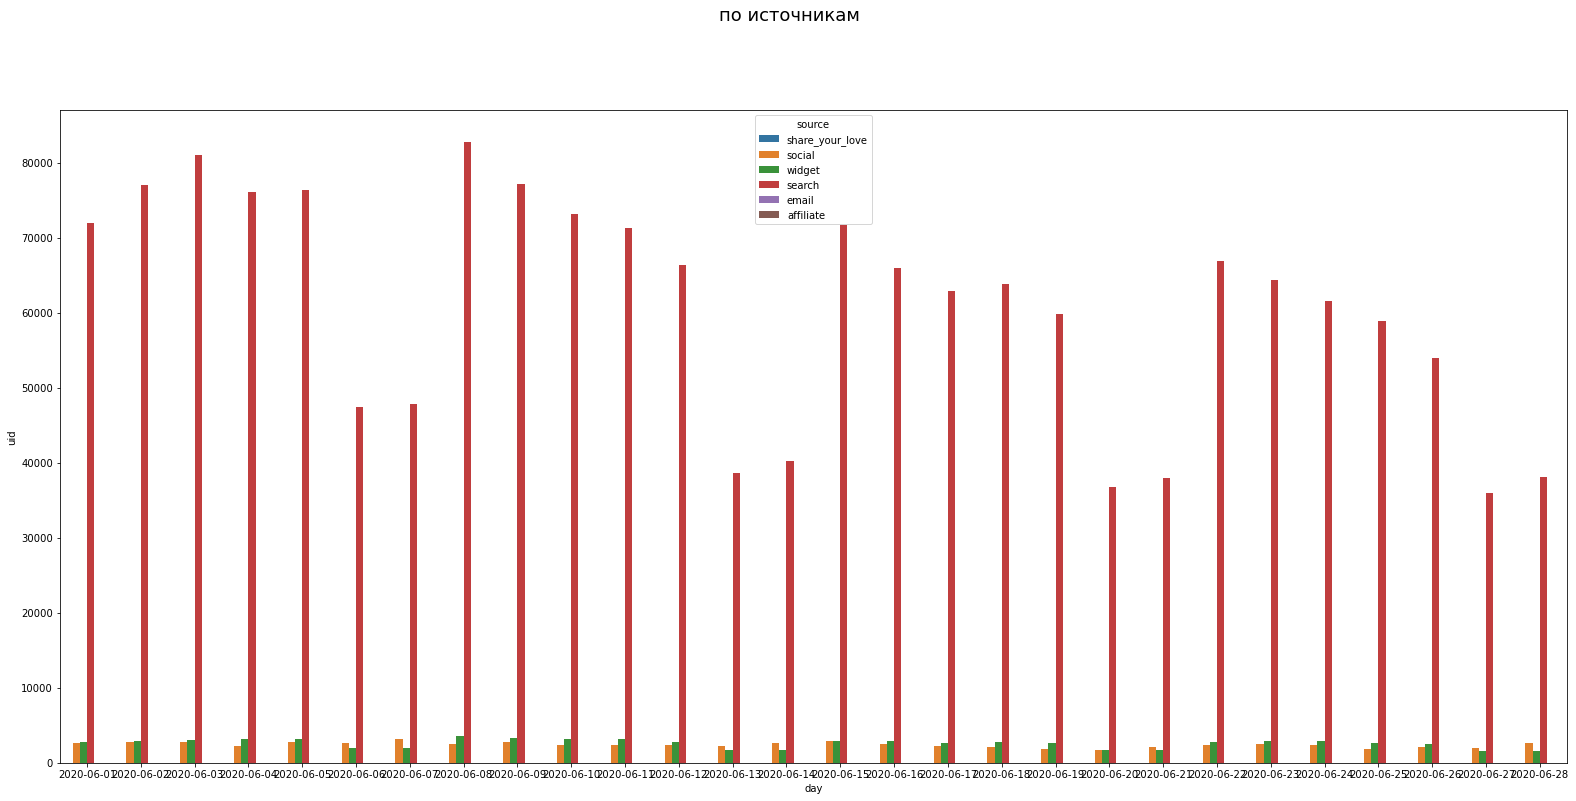

In [137]:
plt.subplots(figsize = (27,12))
sns.barplot(x = 'day', y='uid',hue = 'source', data=ob_type_d, ax = plt.subplot(1, 1, 1))
plt.suptitle('по источникам',fontsize=18, y=1)

Text(0.5, 1, 'по источникам')

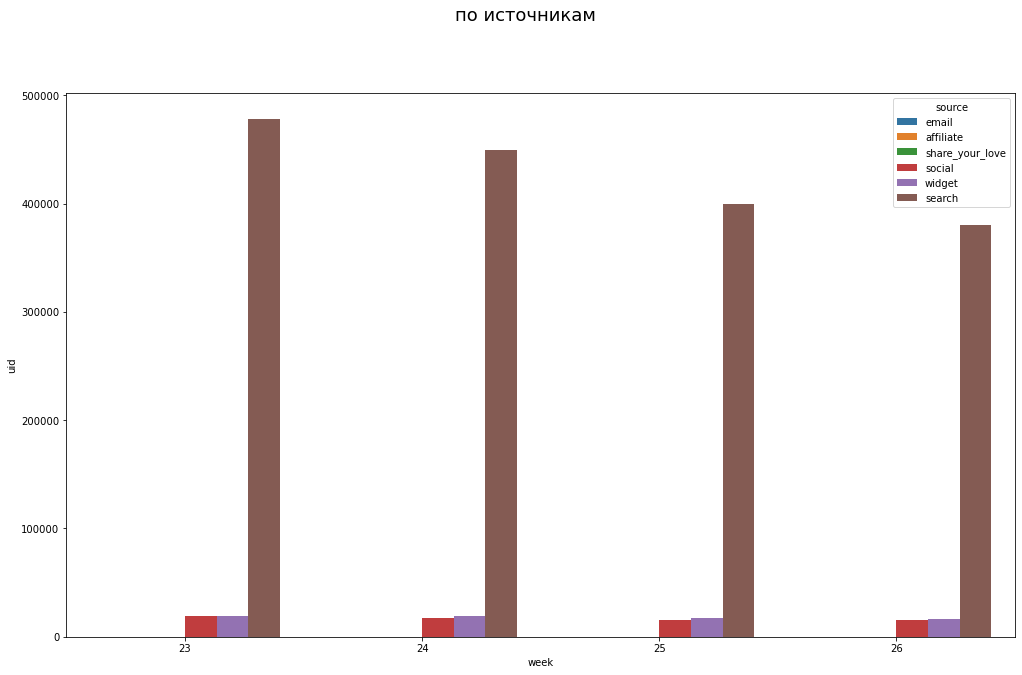

In [138]:
plt.subplots(figsize = (17,10))
sns.barplot(x = 'week', y='uid',hue = 'source', data=ob_type_w, ax = plt.subplot(1, 1, 1))
plt.suptitle('по источникам',fontsize=18, y=1)

 <div style="border:solid blue 2px; padding: 20px">
    По данным за первые 4 недели , основной трафик идет из поиска, такжк из виджетов, и соц. сетей , но в значительно меньшей мере. Как видим из графика по дням в выходные трафик падает.

**сделать аналитическую оценку в общем**

In [139]:
df_4['week'] = df_4['collector_tstamp'].dt.week

In [140]:
# df_4['week'] = df_4['week'].astype(str)

In [141]:
ob_type = df_4.groupby(['week','source']).agg({'uid': 'nunique'}).reset_index().sort_values(by=['week'])

In [142]:
# ob_type

In [26]:
# fig = px.bar(ob_type, x="week", y="uid",
# #              barmode="group", 
#              color='source', 
# #              hover_data=['week'],
#             title='По источникам трафика')
# fig.show()

Text(0.5, 1, 'по источникам')

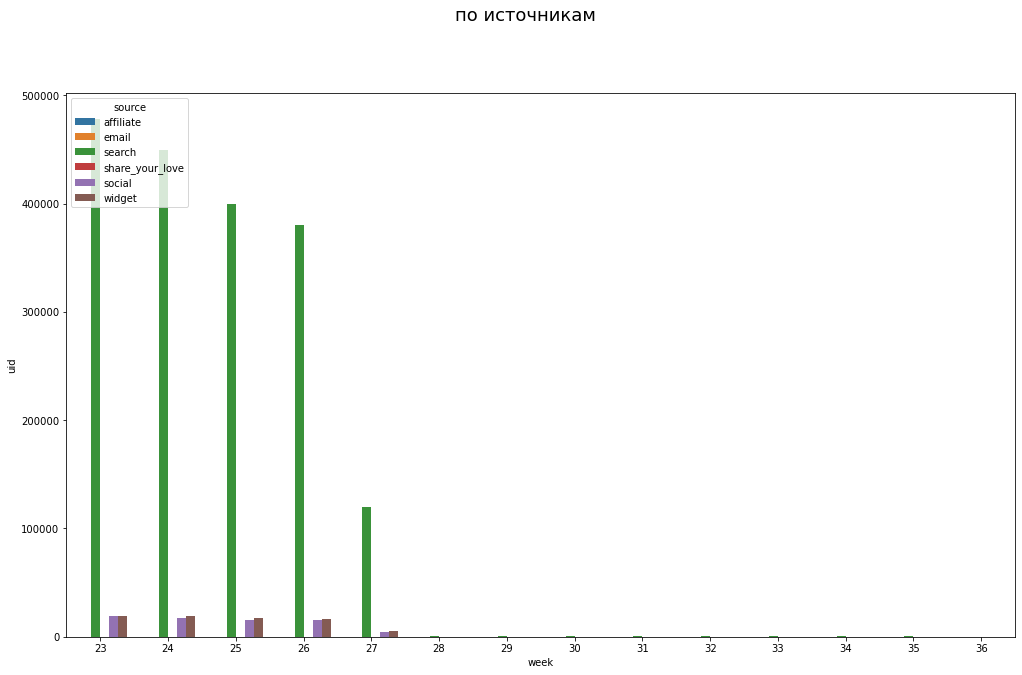

In [144]:
plt.subplots(figsize = (17,10))
sns.barplot(x = 'week', y='uid',hue = 'source', data=ob_type, ax = plt.subplot(1, 1, 1))
plt.suptitle('по источникам',fontsize=18, y=1)

 <div style="border:solid blue 2px; padding: 20px">
    В общем картина сохраняется, но 

## Задание 5 - посадочные страницы

Задание:
- на основе page_urlpath разобрать посадочные страницы на группы
- какие группы/страницы больше всего приносят трафика?
- какие группы/страницы лучше конвертят в регистрации и триалы?

In [28]:
df_1

,platform,collector_tstamp,event_name,user_id,domain_userid,page_urlpath,page_urlquery,refr_urlhost,refr_urlpath,refr_medium,refr_source,mkt_medium,mkt_source,mkt_term,mkt_content,mkt_campaign,pd_feature_id,pd_dialog_action,trial_product,trial_action,product_bill,uid,hit
0,web,2020-06-09 21:36:44,page_view,NaN,00000064-d28a-48c5-b43b-b27b1d080246,/covid19/,NaN,www.google.com,/,search,Google,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00000064-d28a-48c5-b43b-b27b1d080246,1.0
1,web,2020-06-09 21:36:56,page_view,NaN,00000064-d28a-48c5-b43b-b27b1d080246,/covid19/,NaN,www.google.com,/,search,Google,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00000064-d28a-48c5-b43b-b27b1d080246,2.0
2,web,2020-06-14 19:28:23,page_view,NaN,000000c5-18c9-49c3-b670-5a36b5657f82,/markets/stocks-turkey/market-movers-most-vola...,NaN,www.google.com.tr,/,search,Google,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,000000c5-18c9-49c3-b670-5a36b5657f82,1.0
3,web,2020-06-14 19:28:42,page_view,NaN,000000c5-18c9-49c3-b670-5a36b5657f82,/markets/stocks-turkey/market-movers-active/,NaN,NaN,/markets/stocks-turkey/market-movers-most-vola...,internal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,000000c5-18c9-49c3-b670-5a36b5657f82,2.0
4,web,2020-06-08 09:55:34,page_view,NaN,00000787-0193-4b3a-a7ab-a8c04bde3e5b,/symbols/USOIL/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00000787-0193-4b3a-a7ab-a8c04bde3e5b,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28943250,web,2020-06-03 13:35:53,page_view,NaN,ffffe957-5168-4da7-9e4c-9631fc5cb15c,/symbols/TVC-DXY/,NaN,www.google.com,/,search,Google,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ffffe957-5168-4da7-9e4c-9631fc5cb15c,1.0
28943251,web,2020-06-06 04:58:23,page_view,NaN,ffffeba3-9164-4e0a-93a6-f770707c00f1,/symbols/USDJPY/,utm_source=realtime-chart.info&utm_medium=widg...,s.tradingview.com,/,unknown,NaN,widget,realtime-chart.info,FX:USDJPY,NaN,chart,NaN,NaN,NaN,NaN,NaN,ffffeba3-9164-4e0a-93a6-f770707c00f1,1.0
28943252,web,2020-06-06 05:06:49,page_view,NaN,ffffeba3-9164-4e0a-93a6-f770707c00f1,/symbols/USDJPY/,utm_source=realtime-chart.info&utm_medium=widg...,s.tradingview.com,/,unknown,NaN,widget,realtime-chart.info,FX:USDJPY,NaN,chart,NaN,NaN,NaN,NaN,NaN,ffffeba3-9164-4e0a-93a6-f770707c00f1,2.0
28943253,web,2020-06-30 19:31:13,page_view,NaN,fffffb7e-3692-4c07-a4aa-a0d8922e37d1,/markets/stocks-turkey/market-movers-active/,NaN,www.google.com,/,search,Google,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fffffb7e-3692-4c07-a4aa-a0d8922e37d1,1.0


In [29]:
page_urlpath_lst = list(set(df_1.page_urlpath.to_list()))

In [30]:
len(page_urlpath_lst)

644634

In [31]:
# пример
page_urlpath_lst[1]

'/ideas/search/alok/'

поле `page_urlpath` разделено на `/` , разобью поле по этому символу.  

In [32]:
new_df = df_1['page_urlpath'].str.split('/', n=2, expand=True)

In [33]:
new_df

,0,1,2
0,,covid19,
1,,covid19,
2,,markets,stocks-turkey/market-movers-most-volatile/
3,,markets,stocks-turkey/market-movers-active/
4,,symbols,USOIL/
...,...,...,...
28943250,,symbols,TVC-DXY/
28943251,,symbols,USDJPY/
28943252,,symbols,USDJPY/
28943253,,markets,stocks-turkey/market-movers-active/


In [35]:
new_df[1].isna().sum()

775021

In [36]:
new_df[new_df[1] == '']

,0,1,2
10,,,None
12,,,None
14,,,None
15,,,None
22,,,None
...,...,...,...
28943172,,,None
28943182,,,None
28943213,,,None
28943234,,,None


много пустых значений

заменяю пустые значения

In [38]:
new_df.loc[ (new_df[1] == '' ) , 1] = 'empty'

присоединяю группы

In [40]:
df_1 = pd.concat([df_1, new_df[[1,2]]],axis=1)

In [41]:
df_1 = df_1.rename(columns = {1: 'group_1', 2: 'group_2'})

In [44]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28580279 entries, 0 to 28943254
Data columns (total 25 columns):
 #   Column            Dtype         
---  ------            -----         
 0   platform          object        
 1   collector_tstamp  datetime64[ns]
 2   event_name        object        
 3   user_id           float64       
 4   domain_userid     object        
 5   page_urlpath      object        
 6   page_urlquery     object        
 7   refr_urlhost      object        
 8   refr_urlpath      object        
 9   refr_medium       object        
 10  refr_source       object        
 11  mkt_medium        object        
 12  mkt_source        object        
 13  mkt_term          object        
 14  mkt_content       object        
 15  mkt_campaign      object        
 16  pd_feature_id     object        
 17  pd_dialog_action  object        
 18  trial_product     object        
 19  trial_action      object        
 20  product_bill      object        
 21  uid   

**- какие группы/страницы больше всего приносят трафика?**

In [ ]:
# df_5 = df_1[df_1['hit'] == 1]

In [43]:
df_1.group_1.isna().sum()

775021

In [46]:
group_1 = list(set(df_1.group_1.to_list()))
len(group_1)

808

In [47]:
group_2 = list(set(df_1.group_2.to_list()))
len(group_2)

639404

In [ ]:
# т к прочитал из csv поменять тип
# df_5['collector_tstamp'] =  pd.to_datetime(df_5['collector_tstamp'], format='%Y-%m-%d %H:%M:%S')

In [48]:
df_1['week'] = df_1['collector_tstamp'].dt.week

In [49]:
df_symbol = df_1.groupby(['group_1']).agg({'uid': 'nunique'}).sort_values(by=['uid'], ascending=False).reset_index()
# .sort_values(by=['week'], ascending=True)

In [ ]:
# df_symbol['week'] = df_symbol['week'].astype(str)

In [ ]:
# df_symbol.loc[( df_symbol['group_1'] == '') , 'group_1'] = 'empty'

In [53]:
df_symbol = df_symbol[:40]  

In [54]:
df_symbol.isna().sum()

group_1    0
uid        0
dtype: int64

In [57]:
# fig = px.bar(df_symbol, y="group_1", x="uid", color="group_1",
# #              barmode="group",
#             title='трафик по посадочным')
# fig.show()

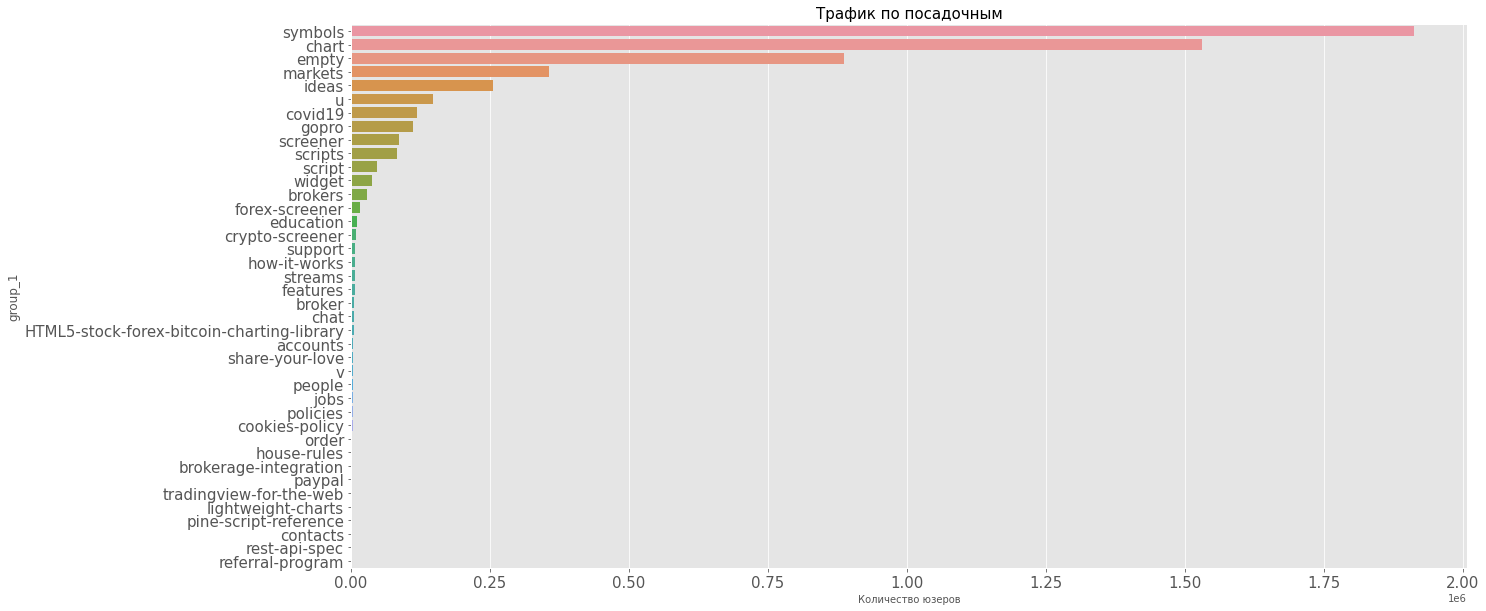

In [56]:
with plt.style.context('ggplot'):
    plt.subplots(figsize = (20,10))
    sns.barplot(x = 'uid', y='group_1', data=df_symbol)
    ax = plt.gca()
    ax.set_xlabel('Количество юзеров',fontsize=10)
    ax.tick_params(axis = 'both',  
                   labelsize = 15)
    plt.title('Трафик по посадочным',fontsize=15, y=1);

**- какие группы/страницы лучше конвертят в регистрации?**

подсказка:
- регистрация - event_name=='user_signup'
- взятие триала - event_name=='trials' & trial_action=='take'

In [ ]:
# т к прочитал из csv поменять тип
# df_1['collector_tstamp'] =  pd.to_datetime(df_1['collector_tstamp'], format='%Y-%m-%d %H:%M:%S')

In [58]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28580279 entries, 0 to 28943254
Data columns (total 26 columns):
 #   Column            Dtype         
---  ------            -----         
 0   platform          object        
 1   collector_tstamp  datetime64[ns]
 2   event_name        object        
 3   user_id           float64       
 4   domain_userid     object        
 5   page_urlpath      object        
 6   page_urlquery     object        
 7   refr_urlhost      object        
 8   refr_urlpath      object        
 9   refr_medium       object        
 10  refr_source       object        
 11  mkt_medium        object        
 12  mkt_source        object        
 13  mkt_term          object        
 14  mkt_content       object        
 15  mkt_campaign      object        
 16  pd_feature_id     object        
 17  pd_dialog_action  object        
 18  trial_product     object        
 19  trial_action      object        
 20  product_bill      object        
 21  uid   

In [60]:
df_1 = df_1.sort_values(['uid','collector_tstamp']).reset_index(drop = True)

**Сдвигаю на одну позицию , чтобы понять откуда был переход на регистрацию**

In [61]:
df_1['event_shift'] = df_1.event_name.shift(1)
df_1['gr_1_shift'] = df_1.group_1.shift(1)

In [62]:
df_signup = df_1[df_1['event_name'] == 'user_signup']

In [63]:
df_signup = df_signup.groupby(['gr_1_shift']).agg({'uid': 'nunique'}).sort_values(by=['uid'], ascending=False).reset_index()

In [65]:
df_signup  = df_signup[:20]

In [69]:
# fig = px.bar(df_signup, y="gr_1_shift", x="uid", color="gr_1_shift",
# #              barmode="group",
#             title='конвертация в регистрацию по группам')
# fig.show()

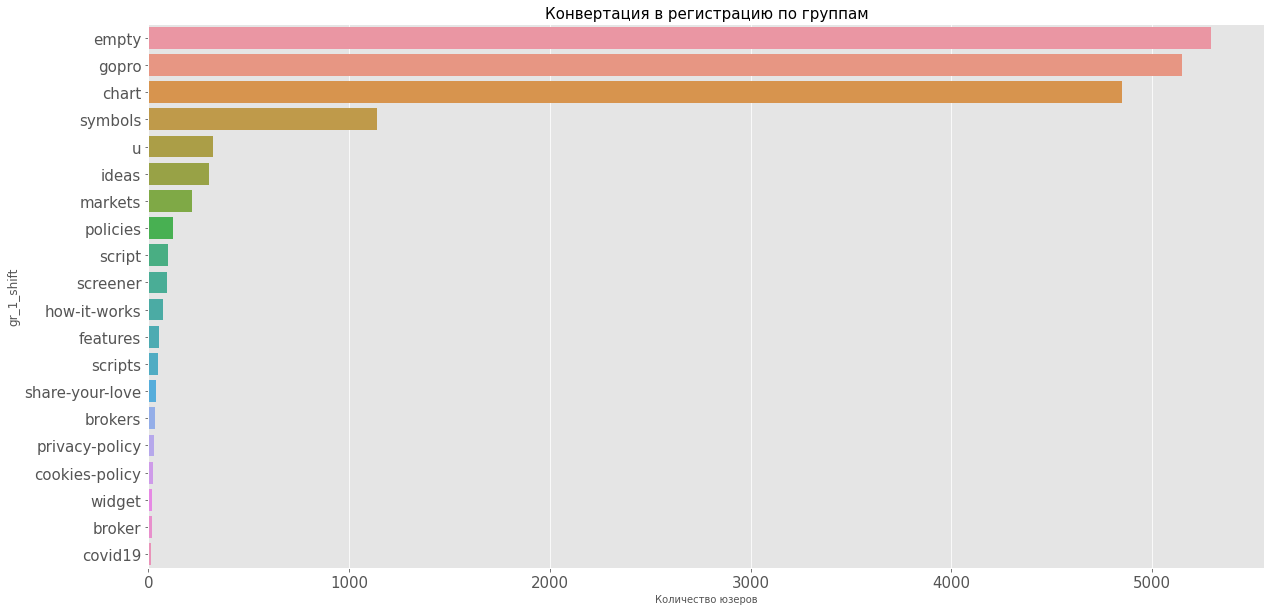

In [70]:
with plt.style.context('ggplot'):
    plt.subplots(figsize = (20,10))
    sns.barplot(x = 'uid', y='gr_1_shift', data=df_signup)
    ax = plt.gca()
    ax.set_xlabel('Количество юзеров',fontsize=10)
    ax.tick_params(axis = 'both',  
                   labelsize = 15)
    plt.title('Конвертация в регистрацию по группам',fontsize=15, y=1);

<div style="border:solid red 2px; padding: 20px">
<font color='red'><b>Написать выводы!!! и построить график по процентам</b>
<div>

**- какие группы/страницы лучше конвертят в триалы?**

подсказка:
- взятие триала - event_name=='trials' & trial_action=='take'

In [71]:
df_trials = df_1[(df_1['event_name'] == 'trials') & (df_1['trial_action'] == 'take')]

In [72]:
df_trials = df_trials.groupby(['gr_1_shift']).agg({'uid': 'nunique'}).sort_values(by=['uid'], ascending=False).reset_index()

In [73]:
df_trials

,gr_1_shift,uid
0,gopro,1624
1,chart,10
2,policies,6
3,symbols,6
4,privacy-policy,5
5,u,3
6,empty,2
7,scripts,1


In [76]:
# fig = px.bar(df_trials, y="gr_1_shift", x="uid", color="gr_1_shift",
# #              barmode="group",
#             title='конвертация в триалы по группам')
# fig.show()

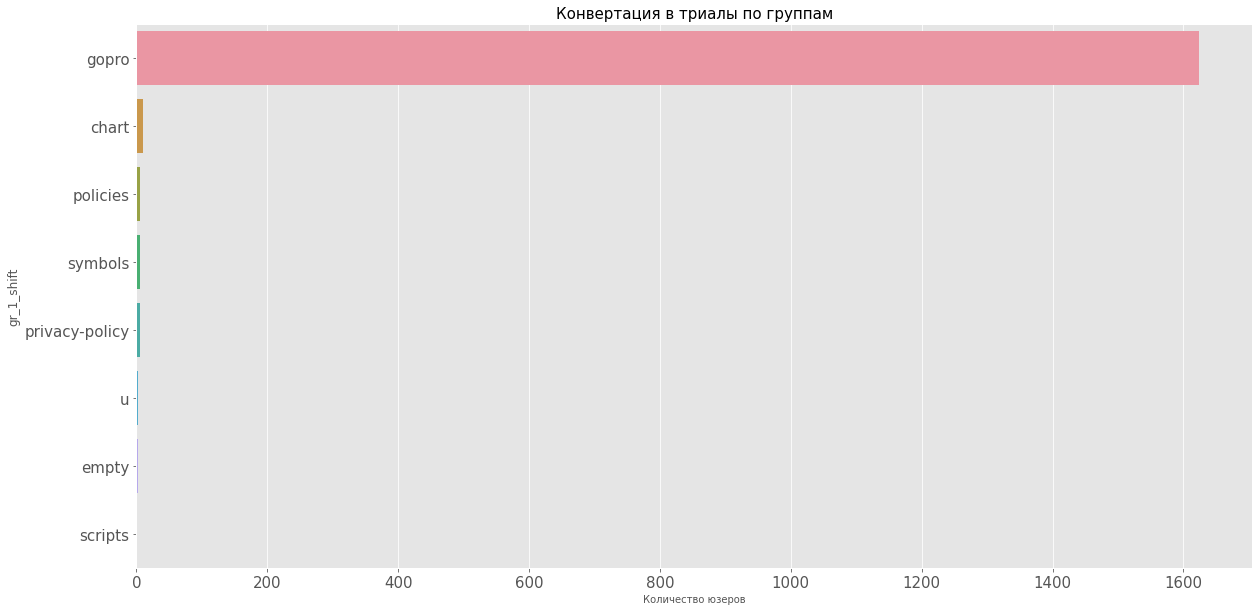

In [75]:
with plt.style.context('ggplot'):
    plt.subplots(figsize = (20,10))
    sns.barplot(x = 'uid', y='gr_1_shift', data=df_trials)
    ax = plt.gca()
    ax.set_xlabel('Количество юзеров',fontsize=10)
    ax.tick_params(axis = 'both',  
                   labelsize = 15)
    plt.title('Конвертация в триалы по группам',fontsize=15, y=1);

<div style="border:solid red 2px; padding: 20px">
<font color='red'><b>Написать выводы!!! и построить график по процентам</b>
<div>

In [77]:
df_1

,platform,collector_tstamp,event_name,user_id,domain_userid,page_urlpath,page_urlquery,refr_urlhost,refr_urlpath,refr_medium,refr_source,mkt_medium,mkt_source,mkt_term,mkt_content,mkt_campaign,pd_feature_id,pd_dialog_action,trial_product,trial_action,product_bill,uid,hit,group_1,group_2,week,event_shift,gr_1_shift
0,web,2020-06-09 21:36:44,page_view,NaN,00000064-d28a-48c5-b43b-b27b1d080246,/covid19/,NaN,www.google.com,/,search,Google,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00000064-d28a-48c5-b43b-b27b1d080246,1.0,covid19,,24,NaN,NaN
1,web,2020-06-09 21:36:56,page_view,NaN,00000064-d28a-48c5-b43b-b27b1d080246,/covid19/,NaN,www.google.com,/,search,Google,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00000064-d28a-48c5-b43b-b27b1d080246,2.0,covid19,,24,page_view,covid19
2,web,2020-06-14 19:28:23,page_view,NaN,000000c5-18c9-49c3-b670-5a36b5657f82,/markets/stocks-turkey/market-movers-most-vola...,NaN,www.google.com.tr,/,search,Google,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,000000c5-18c9-49c3-b670-5a36b5657f82,1.0,markets,stocks-turkey/market-movers-most-volatile/,24,page_view,covid19
3,web,2020-06-14 19:28:42,page_view,NaN,000000c5-18c9-49c3-b670-5a36b5657f82,/markets/stocks-turkey/market-movers-active/,NaN,NaN,/markets/stocks-turkey/market-movers-most-vola...,internal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,000000c5-18c9-49c3-b670-5a36b5657f82,2.0,markets,stocks-turkey/market-movers-active/,24,page_view,markets
4,web,2020-06-08 09:55:34,page_view,NaN,00000787-0193-4b3a-a7ab-a8c04bde3e5b,/symbols/USOIL/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00000787-0193-4b3a-a7ab-a8c04bde3e5b,1.0,symbols,USOIL/,24,page_view,markets
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28580274,web,2020-06-03 13:35:53,page_view,NaN,ffffe957-5168-4da7-9e4c-9631fc5cb15c,/symbols/TVC-DXY/,NaN,www.google.com,/,search,Google,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ffffe957-5168-4da7-9e4c-9631fc5cb15c,1.0,symbols,TVC-DXY/,23,page_view,symbols
28580275,web,2020-06-06 04:58:23,page_view,NaN,ffffeba3-9164-4e0a-93a6-f770707c00f1,/symbols/USDJPY/,utm_source=realtime-chart.info&utm_medium=widg...,s.tradingview.com,/,unknown,NaN,widget,realtime-chart.info,FX:USDJPY,NaN,chart,NaN,NaN,NaN,NaN,NaN,ffffeba3-9164-4e0a-93a6-f770707c00f1,1.0,symbols,USDJPY/,23,page_view,symbols
28580276,web,2020-06-06 05:06:49,page_view,NaN,ffffeba3-9164-4e0a-93a6-f770707c00f1,/symbols/USDJPY/,utm_source=realtime-chart.info&utm_medium=widg...,s.tradingview.com,/,unknown,NaN,widget,realtime-chart.info,FX:USDJPY,NaN,chart,NaN,NaN,NaN,NaN,NaN,ffffeba3-9164-4e0a-93a6-f770707c00f1,2.0,symbols,USDJPY/,23,page_view,symbols
28580277,web,2020-06-30 19:31:13,page_view,NaN,fffffb7e-3692-4c07-a4aa-a0d8922e37d1,/markets/stocks-turkey/market-movers-active/,NaN,www.google.com,/,search,Google,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fffffb7e-3692-4c07-a4aa-a0d8922e37d1,1.0,markets,stocks-turkey/market-movers-active/,27,page_view,symbols


In [78]:
# df_1.to_csv('df_1_5.csv', index = False)

# Задание 6 - permission_dialogs

На странице https://www.tradingview.com/gopro/ представлены все планы подписки и ограничения по ним. 

В тех случаях, когда пользователь превышает лимиты или иначе попадает на ограничения, появляются в интерфейсе диалоговые окна с описание ограничения + события в трекинге ("event_name=='permission_dialogs'")

Расшифровка событий в столбцах
- pd_feature_id - название ограничения, в этом датасете они зашифрованы
- pd_dialog_action - типы события, open - появление диалогового окна, accept - пользователь заинтересовался и "нажал ОК", т.н. перешёл дальне на страницу /gopro

Задание:
- какие permission_dialogs больше всего влияют на регистрации и взятия триалов?
- посчитать конверт заинтересованности юзеров, т.е. открытие диаложки и переход. open->accept

**получается что нужно посмотреть воронку перехода в регистрацию по каждому "pd"  
необходимо отобрать такие регистрации, которые были ПОСЛЕ permission_dialogs**

In [79]:
df_6 = df_1[(df_1['event_name'] == 'user_signup')]

In [80]:
# делаем список юзеров которые зарегистрировались
signup_uid_lst = df_6['uid'].to_list()

In [81]:
signup_uid_lst = list(set(signup_uid_lst))

In [82]:
len(signup_uid_lst)

17716

In [83]:
# датафрейм с юзерами у которых в events есть хотя бы одна регистрация
df_signup = df_1[ (df_1['uid'].isin(signup_uid_lst))] 

In [84]:
# среди них отбираю кому показывали pd
df_signup_pd = df_signup[df_signup['event_name'] == 'permission_dialogs']

In [85]:
# делаем список таких юзеров
signup_pd_lst = df_signup_pd['uid'].to_list()
signup_pd_lst = list(set(signup_pd_lst))

In [86]:
df_7 = df_1[ (df_1['uid'].isin(signup_pd_lst))] 

In [88]:
# получили датафрейм тех кто зарегился и кому показывали pd
# df_7

**чтобы поосчитать какие permission_dialogs больше всего влияют на регистрации  
необходимо отобрать те pd, которые были перед регистрацией**
1. отбираю `pd`
2. `merge` `inner` регистрации по `uid` 
3. вычисляю `delta` по времени 
4. отбираю минимальную  `delta`

In [89]:
df_7 = df_7.sort_values(['uid','collector_tstamp']).reset_index(drop = True)

**отбираю pd**

In [90]:
#отбираю ивент pd среди тех кто зарегился
df_pd_uid = df_7[df_7['event_name'] == 'permission_dialogs']

In [91]:
df_pd_uid = df_pd_uid[['uid','event_name','collector_tstamp','pd_feature_id','pd_dialog_action']]

In [92]:
df_pd_uid

,uid,event_name,collector_tstamp,pd_feature_id,pd_dialog_action
3,1007197.0,permission_dialogs,2020-06-21 15:10:38,pd_5,open
4,1007197.0,permission_dialogs,2020-06-21 15:10:42,pd_1,open
5,1007197.0,permission_dialogs,2020-06-21 15:11:57,pd_5,open
6,1007197.0,permission_dialogs,2020-06-21 15:12:58,pd_5,open
72,1007197.0,permission_dialogs,2020-08-12 10:20:33,pd_1,open
...,...,...,...,...,...
1395413,99541.0,permission_dialogs,2020-08-27 11:53:37,pd_1,close_button
1395415,99541.0,permission_dialogs,2020-08-27 13:11:26,pd_1,open
1395416,99541.0,permission_dialogs,2020-08-27 13:11:27,pd_1,close_button
1395417,99541.0,permission_dialogs,2020-08-27 15:20:55,pd_5,open


In [93]:
df_pd_uid.uid.nunique()

12186

In [95]:
#отбираю ивент регистрация
df_s_uid = df_7[(df_7['event_name'] =='user_signup') ]

In [96]:
df_s_uid = df_s_uid[['uid','event_name','collector_tstamp']]

In [97]:
df_s_uid

,uid,event_name,collector_tstamp
136,1007197.0,user_signup,2020-08-20 09:26:00
417,1007991.0,user_signup,2020-08-22 11:04:52
555,1013667.0,user_signup,2020-08-31 07:50:28
574,1018730.0,user_signup,2020-06-25 13:41:13
612,1048565.0,user_signup,2020-08-21 01:47:39
...,...,...,...
1393657,982195.0,user_signup,2020-07-20 10:24:53
1394042,982196.0,user_signup,2020-07-31 15:06:26
1394633,989499.0,user_signup,2020-07-09 00:28:46
1394722,989499.0,user_signup,2020-07-16 19:23:37


**есть дубликаты**

In [98]:
df_s_uid.uid.nunique()

12186

In [99]:
df_s_uid[df_s_uid.duplicated(['uid'], keep=False)]

,uid,event_name,collector_tstamp
4574,1114805.0,user_signup,2020-06-22 01:57:45
4580,1114805.0,user_signup,2020-06-22 11:59:38
4598,1114805.0,user_signup,2020-06-23 09:23:11
4605,1114805.0,user_signup,2020-06-23 09:44:46
4611,1114805.0,user_signup,2020-06-23 10:00:54
...,...,...,...
1388468,875359.0,user_signup,2020-08-24 11:00:36
1393240,974675.0,user_signup,2020-06-23 14:30:27
1393241,974675.0,user_signup,2020-06-23 14:32:29
1394633,989499.0,user_signup,2020-07-09 00:28:46


In [100]:
df_pd_s_uid = df_pd_uid.merge(df_s_uid , on = ['uid'], how = 'inner')

In [101]:
df_pd_s_uid

,uid,event_name_x,collector_tstamp_x,pd_feature_id,pd_dialog_action,event_name_y,collector_tstamp_y
0,1007197.0,permission_dialogs,2020-06-21 15:10:38,pd_5,open,user_signup,2020-08-20 09:26:00
1,1007197.0,permission_dialogs,2020-06-21 15:10:42,pd_1,open,user_signup,2020-08-20 09:26:00
2,1007197.0,permission_dialogs,2020-06-21 15:11:57,pd_5,open,user_signup,2020-08-20 09:26:00
3,1007197.0,permission_dialogs,2020-06-21 15:12:58,pd_5,open,user_signup,2020-08-20 09:26:00
4,1007197.0,permission_dialogs,2020-08-12 10:20:33,pd_1,open,user_signup,2020-08-20 09:26:00
...,...,...,...,...,...,...,...
408310,99541.0,permission_dialogs,2020-08-27 11:53:37,pd_1,close_button,user_signup,2020-07-14 21:02:55
408311,99541.0,permission_dialogs,2020-08-27 13:11:26,pd_1,open,user_signup,2020-07-14 21:02:55
408312,99541.0,permission_dialogs,2020-08-27 13:11:27,pd_1,close_button,user_signup,2020-07-14 21:02:55
408313,99541.0,permission_dialogs,2020-08-27 15:20:55,pd_5,open,user_signup,2020-07-14 21:02:55


In [103]:
df_pd_s_uid['delta'] = df_pd_s_uid['collector_tstamp_y'] - df_pd_s_uid['collector_tstamp_x']

In [105]:
df_pd_s_uid['rank'] = df_pd_s_uid.groupby("uid")["delta"].rank(method="first", ascending=True)

In [106]:
df_pd_s_uid = df_pd_s_uid[df_pd_s_uid['rank'] == 1]

In [107]:
df_pd_s_uid

,uid,event_name_x,collector_tstamp_x,pd_feature_id,pd_dialog_action,event_name_y,collector_tstamp_y,delta,rank
24,1007197.0,permission_dialogs,2020-08-20 09:41:10,pd_6,close_button,user_signup,2020-08-20 09:26:00,-1 days +23:44:50,1.0
116,1007991.0,permission_dialogs,2020-08-31 18:40:40,pd_5,close_button,user_signup,2020-08-22 11:04:52,-10 days +16:24:12,1.0
124,1013667.0,permission_dialogs,2020-08-31 07:45:45,pd_1,close_button,user_signup,2020-08-31 07:50:28,0 days 00:04:43,1.0
125,1018730.0,permission_dialogs,2020-06-25 09:20:47,pd_5,open,user_signup,2020-06-25 13:41:13,0 days 04:20:26,1.0
133,1048565.0,permission_dialogs,2020-08-21 01:50:55,pd_8,accept,user_signup,2020-08-21 01:47:39,-1 days +23:56:44,1.0
...,...,...,...,...,...,...,...,...,...
407447,978702.0,permission_dialogs,2020-06-24 14:31:42,pd_6,open,user_signup,2020-06-22 18:45:20,-2 days +04:13:38,1.0
407454,982195.0,permission_dialogs,2020-07-20 15:05:11,pd_1,open,user_signup,2020-07-20 10:24:53,-1 days +19:19:42,1.0
407533,982196.0,permission_dialogs,2020-08-11 21:27:33,pd_8,close_button,user_signup,2020-07-31 15:06:26,-12 days +17:38:53,1.0
408260,989499.0,permission_dialogs,2020-08-31 16:35:03,pd_1,close_button,user_signup,2020-07-09 00:28:46,-54 days +07:53:43,1.0


In [108]:
ob_type = df_pd_s_uid.groupby(['pd_feature_id']).agg({'uid': 'nunique'}).reset_index().sort_values(by=['uid'], ascending=False)

In [109]:
ob_type

,pd_feature_id,uid
0,pd_1,6742
6,pd_6,1958
5,pd_5,1324
8,pd_8,828
9,pd_9,436
7,pd_7,326
3,pd_3,211
4,pd_4,160
2,pd_2,115
1,pd_10,86


In [112]:
# fig = px.bar(ob_type, y="pd_feature_id", x="uid", color="pd_feature_id",
# #              barmode="group",
#             title='переходы с pd в регистрации')
# fig.show()

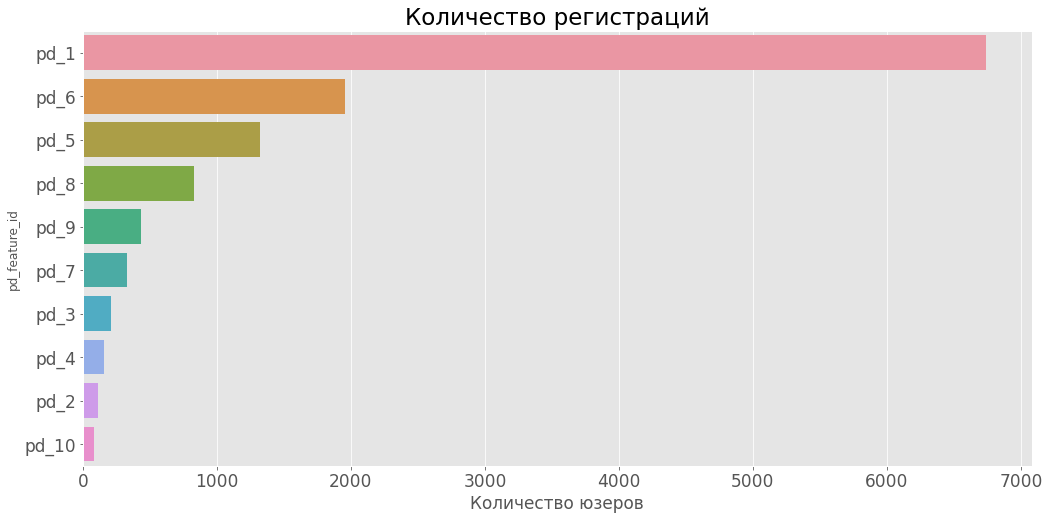

In [111]:
with plt.style.context('ggplot'):
    plt.subplots(figsize = (17,8))
    sns.barplot(x = 'uid', y='pd_feature_id', data=ob_type)
    ax = plt.gca()
    ax.set_xlabel('Количество юзеров',fontsize=17)
    ax.tick_params(axis = 'both',  
                   labelsize = 17)
    plt.title('Переходы с pd в регистрации',fontsize=23, y=1);

<div style="border:solid red 2px; padding: 20px">
<font color='red'><b>Написать выводы!!! и построить график по процентам</b>
<div>

**чтобы поосчитать какие permission_dialogs больше всего влияют на взятие тиралов  
необходимо отобрать те pd, которые были перед взятием триалов**

In [113]:
df_6 = df_1[(df_1['event_name'] == 'trials') & (df_1['trial_action'] == 'take')]

In [114]:
# делаем список таких юзеров
trial_uid_lst = df_6['uid'].to_list()

In [115]:
trial_uid_lst = list(set(trial_uid_lst))

In [116]:
# количество юзеров кому показывали 'permission_dialogs'
len(trial_uid_lst)

1665

In [117]:
# датафрейм с юзерами у который в events есть вятие тралов
df_trials = df_1[ (df_1['uid'].isin(trial_uid_lst))] 

In [118]:
#отбираю ивент pd среди тех кто взял триал
df_trials_pd = df_trials[df_trials['event_name'] == 'permission_dialogs']

In [119]:
# делаем список таких юзеров
trials_pd_lst = df_trials_pd['uid'].to_list()
trials_pd_lst = list(set(trials_pd_lst))

In [120]:
df_7 = df_1[ (df_1['uid'].isin(trials_pd_lst))] 

In [122]:
# это датафрейм в котором есть и взятие триалов и pd
# df_7

1. отбираю `pd`
2. `merge` `inner` регистрации по `uid` 
3. вычисляю `delta` по времени 
4. отбираю минимальную минимальную

In [123]:
df_7 = df_7.sort_values(['uid','collector_tstamp']).reset_index(drop = True)

**отбираю pd**

In [124]:
#отбираю ивент pd среди тех 
df_pd_uid = df_7[df_7['event_name'] == 'permission_dialogs']

In [125]:
df_pd_uid = df_pd_uid[['uid','event_name','collector_tstamp','pd_feature_id','pd_dialog_action']]

In [126]:
df_pd_uid

,uid,event_name,collector_tstamp,pd_feature_id,pd_dialog_action
3,1007197.0,permission_dialogs,2020-06-21 15:10:38,pd_5,open
4,1007197.0,permission_dialogs,2020-06-21 15:10:42,pd_1,open
5,1007197.0,permission_dialogs,2020-06-21 15:11:57,pd_5,open
6,1007197.0,permission_dialogs,2020-06-21 15:12:58,pd_5,open
72,1007197.0,permission_dialogs,2020-08-12 10:20:33,pd_1,open
...,...,...,...,...,...
336400,960537.0,permission_dialogs,2020-07-20 13:48:00,pd_6,open
336524,960537.0,permission_dialogs,2020-08-21 03:54:54,pd_5,open
336525,960537.0,permission_dialogs,2020-08-21 03:54:56,pd_5,close_button
336534,960537.0,permission_dialogs,2020-08-23 09:09:36,pd_5,open


In [128]:
#отбираю ивент pd среди тех 
df_tr_uid = df_7[(df_7['event_name'] =='trials') & (df_7['trial_action'] == 'take')]

In [129]:
df_tr_uid = df_tr_uid[['uid','event_name','trial_action','collector_tstamp']]

In [130]:
df_tr_uid

,uid,event_name,trial_action,collector_tstamp
14,1007197.0,trials,take,2020-07-09 02:13:25
87,1007197.0,trials,take,2020-08-13 08:42:52
209,1007991.0,trials,take,2020-06-11 21:51:44
563,1053458.0,trials,take,2020-07-13 13:27:04
652,1092718.0,trials,take,2020-07-12 14:39:02
...,...,...,...,...
334122,833874.0,trials,take,2020-06-13 23:27:57
334257,909650.0,trials,take,2020-06-09 17:34:31
334802,921385.0,trials,take,2020-07-06 08:57:19
335253,927361.0,trials,take,2020-08-05 03:42:22


**дубликаты есть**

In [131]:
df_tr_uid.uid.nunique()

1348

In [132]:
df_tr_uid[df_tr_uid.duplicated(['uid'], keep=False)].head(5)

,uid,event_name,trial_action,collector_tstamp
14,1007197.0,trials,take,2020-07-09 02:13:25
87,1007197.0,trials,take,2020-08-13 08:42:52
6101,1245905.0,trials,take,2020-06-24 10:08:44
6246,1245905.0,trials,take,2020-07-08 14:01:22
13230,1757639.0,trials,take,2020-06-29 12:32:48


In [133]:
df_pd_tr_uid = df_pd_uid.merge(df_tr_uid , on = ['uid'], how = 'inner')

In [134]:
df_pd_tr_uid['delta'] = df_pd_tr_uid['collector_tstamp_y'] - df_pd_tr_uid['collector_tstamp_x']

In [135]:
df_pd_tr_uid

,uid,event_name_x,collector_tstamp_x,pd_feature_id,pd_dialog_action,event_name_y,trial_action,collector_tstamp_y,delta
0,1007197.0,permission_dialogs,2020-06-21 15:10:38,pd_5,open,trials,take,2020-07-09 02:13:25,17 days 11:02:47
1,1007197.0,permission_dialogs,2020-06-21 15:10:38,pd_5,open,trials,take,2020-08-13 08:42:52,52 days 17:32:14
2,1007197.0,permission_dialogs,2020-06-21 15:10:42,pd_1,open,trials,take,2020-07-09 02:13:25,17 days 11:02:43
3,1007197.0,permission_dialogs,2020-06-21 15:10:42,pd_1,open,trials,take,2020-08-13 08:42:52,52 days 17:32:10
4,1007197.0,permission_dialogs,2020-06-21 15:11:57,pd_5,open,trials,take,2020-07-09 02:13:25,17 days 11:01:28
...,...,...,...,...,...,...,...,...,...
61494,960537.0,permission_dialogs,2020-07-20 13:48:00,pd_6,open,trials,take,2020-06-16 15:57:20,-34 days +02:09:20
61495,960537.0,permission_dialogs,2020-08-21 03:54:54,pd_5,open,trials,take,2020-06-16 15:57:20,-66 days +12:02:26
61496,960537.0,permission_dialogs,2020-08-21 03:54:56,pd_5,close_button,trials,take,2020-06-16 15:57:20,-66 days +12:02:24
61497,960537.0,permission_dialogs,2020-08-23 09:09:36,pd_5,open,trials,take,2020-06-16 15:57:20,-68 days +06:47:44


In [137]:
df_pd_tr_uid['rank'] = df_pd_tr_uid.groupby("uid")["delta"].rank(method="first", ascending=True)

In [138]:
df_pd_tr_uid = df_pd_tr_uid[df_pd_tr_uid['rank'] == 1]

In [139]:
df_pd_tr_uid

,uid,event_name_x,collector_tstamp_x,pd_feature_id,pd_dialog_action,event_name_y,trial_action,collector_tstamp_y,delta,rank
48,1007197.0,permission_dialogs,2020-08-20 09:41:10,pd_6,close_button,trials,take,2020-07-09 02:13:25,-43 days +16:32:15,1.0
141,1007991.0,permission_dialogs,2020-08-31 18:40:40,pd_5,close_button,trials,take,2020-06-11 21:51:44,-81 days +03:11:04,1.0
154,1053458.0,permission_dialogs,2020-08-07 14:00:09,pd_1,close_button,trials,take,2020-07-13 13:27:04,-26 days +23:26:55,1.0
172,1092718.0,permission_dialogs,2020-08-18 10:23:28,pd_1,close_button,trials,take,2020-07-12 14:39:02,-37 days +04:15:34,1.0
298,1109956.0,permission_dialogs,2020-08-29 13:37:51,pd_1,close_button,trials,take,2020-07-07 13:35:14,-54 days +23:57:23,1.0
...,...,...,...,...,...,...,...,...,...,...
61115,833874.0,permission_dialogs,2020-06-13 23:25:46,pd_1,open,trials,take,2020-06-13 23:27:57,0 days 00:02:11,1.0
61386,909650.0,permission_dialogs,2020-08-12 10:20:23,pd_6,accept,trials,take,2020-06-09 17:34:31,-64 days +07:14:08,1.0
61397,921385.0,permission_dialogs,2020-07-16 16:29:49,pd_8,open,trials,take,2020-07-06 08:57:19,-11 days +16:27:30,1.0
61421,927361.0,permission_dialogs,2020-08-05 22:04:26,pd_5,close_button,trials,take,2020-08-05 03:42:22,-1 days +05:37:56,1.0


In [140]:
ob_type = df_pd_tr_uid.groupby(['pd_feature_id']).agg({'uid': 'nunique'}).reset_index().sort_values(by=['uid'], ascending=False)

In [141]:
ob_type

,pd_feature_id,uid
0,pd_1,376
5,pd_5,295
8,pd_8,218
6,pd_6,132
7,pd_7,108
3,pd_3,98
4,pd_4,45
2,pd_2,36
9,pd_9,27
1,pd_10,13


In [144]:
# fig = px.bar(ob_type, y="pd_feature_id", x="uid", color="pd_feature_id",
# #              barmode="group",
#             title='Переходы с pd во взятие триалов')
# fig.show()

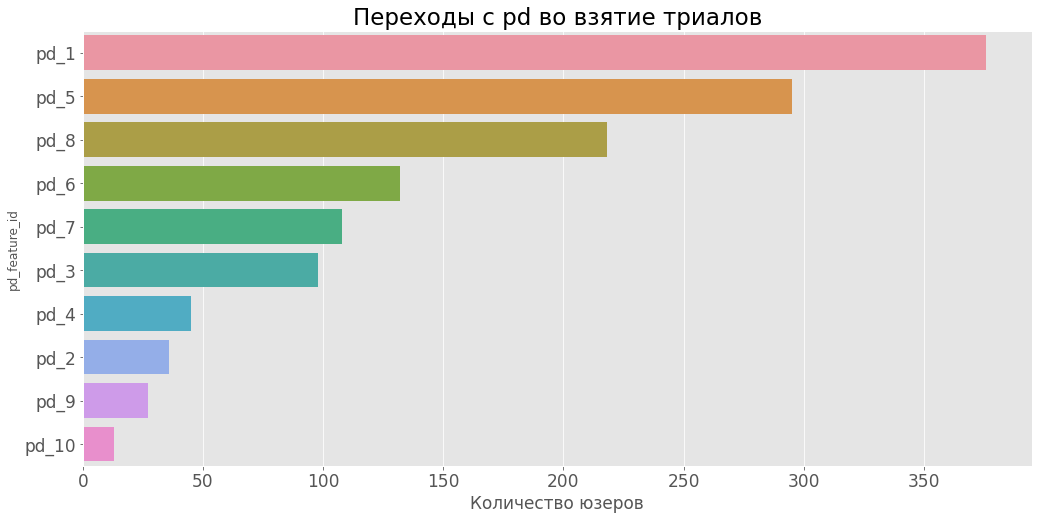

In [143]:
with plt.style.context('ggplot'):
    plt.subplots(figsize = (17,8))
    sns.barplot(x = 'uid', y='pd_feature_id', data=ob_type)
    ax = plt.gca()
    ax.set_xlabel('Количество юзеров',fontsize=17)
    ax.tick_params(axis = 'both',  
                   labelsize = 17)
    plt.title('Переходы с pd во взятие триалов',fontsize=23, y=1);

<div style="border:solid red 2px; padding: 20px">
<font color='red'><b>Написать выводы!!! и построить график по процентам</b>
<div>

**- посчитать конверт заинтересованности юзеров, т.е. открытие диаложки и переход. open->accept**

т к после появления `pd` `open` пользователь переходит либо на `accept` либо закрывет окно, то отбираем пользователей по фильтру ниже

In [145]:
# отбираю пользователей
df_op_ac = df_1[(df_1['event_name'] =='permission_dialogs') &
                ((df_1['pd_dialog_action'] =='open') | (df_1['pd_dialog_action'] == 'accept'))]

In [147]:
all_open = df_op_ac[df_op_ac['pd_dialog_action'] =='open']['pd_dialog_action'].count()

In [148]:
all_accept = df_op_ac[df_op_ac['pd_dialog_action'] =='accept']['pd_dialog_action'].count()

In [149]:
df_op_ac['pd_dialog_action'].value_counts()

open      2197109
accept      31317
Name: pd_dialog_action, dtype: int64

**для юзеров у которых повторяется open и accept**

In [150]:
str(round( (all_accept / all_open *100), 2))  + ' %'

'1.43 %'

<div style="border:solid red 2px; padding: 20px">
<font color='red'><b>Написать выводы!!! и построить график по процентам</b>
<div>

**для одного юзера**

In [151]:
nuniq_open = df_op_ac[df_op_ac['pd_dialog_action'] =='open']['uid'].nunique()
nuniq_open

292557

In [152]:
nuniq_accept = df_op_ac[df_op_ac['pd_dialog_action'] =='accept']['uid'].nunique()
nuniq_accept

21004

In [153]:
str(round( (nuniq_accept / nuniq_open *100), 2))  + ' %'

'7.18 %'

<div style="border:solid red 2px; padding: 20px">
<font color='red'><b>Написать выводы!!! и построить график по процентам</b>
<div>

In [154]:
df_1.to_csv('df_1_6.csv', index = False)

# Задание 7 - Воронка

*новый пользователь -> регистрация -> посещение страницы gopro -> взятие триала -> покупка*

подсказка:
- регистрация - event_name=='user_signup'
- взятие триала - event_name=='trials' & trial_action=='take'
- биллинг/оплата - event_name=='billing'

Задание:
- построить воронку за весь период
- и отдельно по первым четырём неделям
- сделать аналитическу оценку

**перешел на страницу gopro - "event_name=='permission_dialogs'" и pd_dialog_action = accept**

**нужно отобрать пользователей у которых была страница gopro после регистрации**

In [ ]:
# df_1[df_1['event_name'] == 'user_signup'][['uid']].nunique()

In [156]:
df_1['event_funnel'] = df_1['event_name']

In [157]:
# взятие триала
df_1.loc[ ( df_1['event_name'] == 'trials') & (df_1['trial_action'] == 'take')  , 'event_funnel'] = 'trial'

In [158]:
# перешел на страницу gopro
df_1.loc[ ( df_1['event_name'] == 'permission_dialogs') & (df_1['pd_dialog_action'] == 'accept')  , 'event_funnel'] = 'gopro'

In [ ]:
# df_1.groupby('event_name').agg({'uid': 'count'}).reset_index().sort_values(by = 'uid', ascending = False)

In [ ]:
# df_1.groupby('event_name').agg({'uid': 'nunique'}).reset_index().sort_values(by = 'uid', ascending = False)

In [159]:
df_full_Event = df_1.groupby('event_funnel').agg({'uid': 'nunique'}).sort_values(by = 'uid', ascending = False).reset_index()

In [160]:
df_full_Event

,event_funnel,uid
0,page_view,3566669
1,permission_dialogs,292558
2,gopro,21004
3,user_signup,17716
4,application_foreground,10559
5,logins,8646
6,trials,6648
7,trial,1665
8,billing,160


In [161]:
df_full_Event = df_full_Event.iloc[[0,3,2,7,8]].reset_index(drop = True)

In [162]:
df_full_Event['Shift'] = df_full_Event.uid.shift(1)

In [163]:
df_full_Event.loc[ df_full_Event['Shift'].isna() , 'Shift'] = df_full_Event['uid']

In [164]:
df_full_Event['% Previous'] = ((df_full_Event['uid']/df_full_Event['Shift'])*100).round(3)

In [165]:
df_full_Event['% of initial'] = ((df_full_Event['uid']/df_full_Event['uid'][0])*100).round(3)

In [166]:
df_full_Event

,event_funnel,uid,Shift,% Previous,% of initial
0,page_view,3566669,3566669.0,100.000,100.000
1,user_signup,17716,3566669.0,0.497,0.497
2,gopro,21004,17716.0,118.559,0.589
3,trial,1665,21004.0,7.927,0.047
4,billing,160,1665.0,9.610,0.004


**получается те кто зарегистрировался переходили на страницу gopro несколько раз**

 <div style="border:solid blue 2px; padding: 20px">
    
 `% Previous` - Это доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).  
 `% of initial` - это доля от первоначального числа. 

In [167]:
y = [4,3,2,1,0]
x = df_full_Event['uid']

In [168]:
# from matplotlib import font_manager as fm

In [169]:
# funnel chart
labels =df_full_Event['event_funnel']
x_max = 2000000
x_min = 0
x_range = x_max - x_min

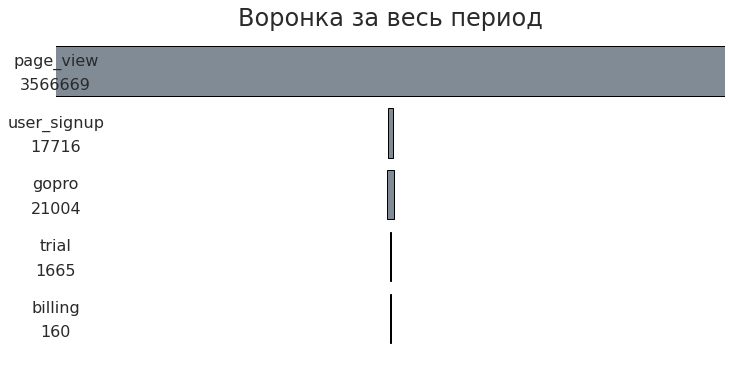

In [170]:
fig, ax = plt.subplots(1, figsize=(12,6))
for idx, val in enumerate(x):
    left = (x_range - val)/2
    plt.barh(y[idx], x[idx], left = left, color='#808B96',
             height=.8, edgecolor='black')
    # label
    plt.text(50, y[idx]+0.1, labels[idx], ha='center', 
#              fontproperties= font,
             fontsize=16, color='#2A2A2A')
    # value
    plt.text(50, y[idx]-0.3, x[idx], ha='center',
#              fontproperties=font,
             fontsize=16, color='#2A2A2A')
    
plt.xlim(x_min, x_max)
plt.axis('off')
plt.title('Воронка за весь период',
#           fontproperties=font, 
          loc='center', fontsize=24, color='#2A2A2A')
plt.show()

In [ ]:
# fig = go.Figure(go.Funnel( hoverinfo = "skip",
#     y = df_full_Event['event_funnel'],
#     x = df_full_Event['% Previous'],
#      textposition = "inside",
#     textinfo = "value+percent previous",
#     opacity = 0.65, marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal", "silver"],
#     "line": {"width": [4, 2, 2, 3, 1, 1], "color": ["wheat", "wheat", "blue", "wheat", "wheat"]}},
#     connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}})
#     )
# fig.show()

In [ ]:
# fig = go.Figure()
# fig.add_trace(go.Funnel(
#     y = df_full_Event['event_funnel'],
#     x = df_full_Event['uid'],
#     textinfo = "value+percent previous"))
# # fig.update_layout(plot_bgcolor='#fff')

# Задание 8 - Метрики

посчитать метрики: 
- DAU, WAU, MAU
- Stickness (коэффициент липкости)
- 7 day Retention Rate, 30-day Retention Rate, 60-day Retention Rate
- Paying Share

**DAU, WAU, MAU**

In [171]:
df_1['day'] = df_1['collector_tstamp'].dt.date
df_1['week'] = df_1['collector_tstamp'].dt.week
df_1['month'] = df_1['collector_tstamp'].dt.month
df_1['year'] = df_1['collector_tstamp'].dt.year

In [ ]:
df_1

In [172]:
dau_total = df_1.groupby('day').agg({'uid': 'nunique'}).mean()

In [173]:
dau_total

uid    69624.44086
dtype: float64

In [174]:
wau_total = df_1.groupby(['year','week']).agg({'uid': 'nunique'}).mean()

In [175]:
wau_total

uid    342047.0
dtype: float64

In [176]:
mau_total = df_1.groupby(['year','month']).agg({'uid': 'nunique'}).mean()

In [177]:
mau_total

uid    1007323.75
dtype: float64

In [178]:
print('DAU = ',int(dau_total))
print('WAU = ',int(wau_total))
print('MAU = ',int(mau_total))

DAU =  69624
WAU =  342047
MAU =  1007323


<div style="border:solid blue 2px; padding: 20px">
Рассмотрим в динамике изменение DAU, WAU, MAU
</div>

In [179]:
dau = df_1.groupby(['year','day']).agg({'uid': 'nunique'}).reset_index()
wau = df_1.groupby(['year','week']).agg({'uid': 'nunique'}).reset_index()
mau = df_1.groupby(['year','month']).agg({'uid': 'nunique'}).reset_index()

In [180]:
mau

,year,month,uid
0,2020,6,3555680
1,2020,7,310737
2,2020,8,162877
3,2020,9,1


In [181]:
dau

,year,day,uid
0,2020,2020-06-01,136160
1,2020,2020-06-02,160150
2,2020,2020-06-03,168117
3,2020,2020-06-04,165927
4,2020,2020-06-05,169381
...,...,...,...
88,2020,2020-08-28,20417
89,2020,2020-08-29,11134
90,2020,2020-08-30,11368
91,2020,2020-08-31,21232


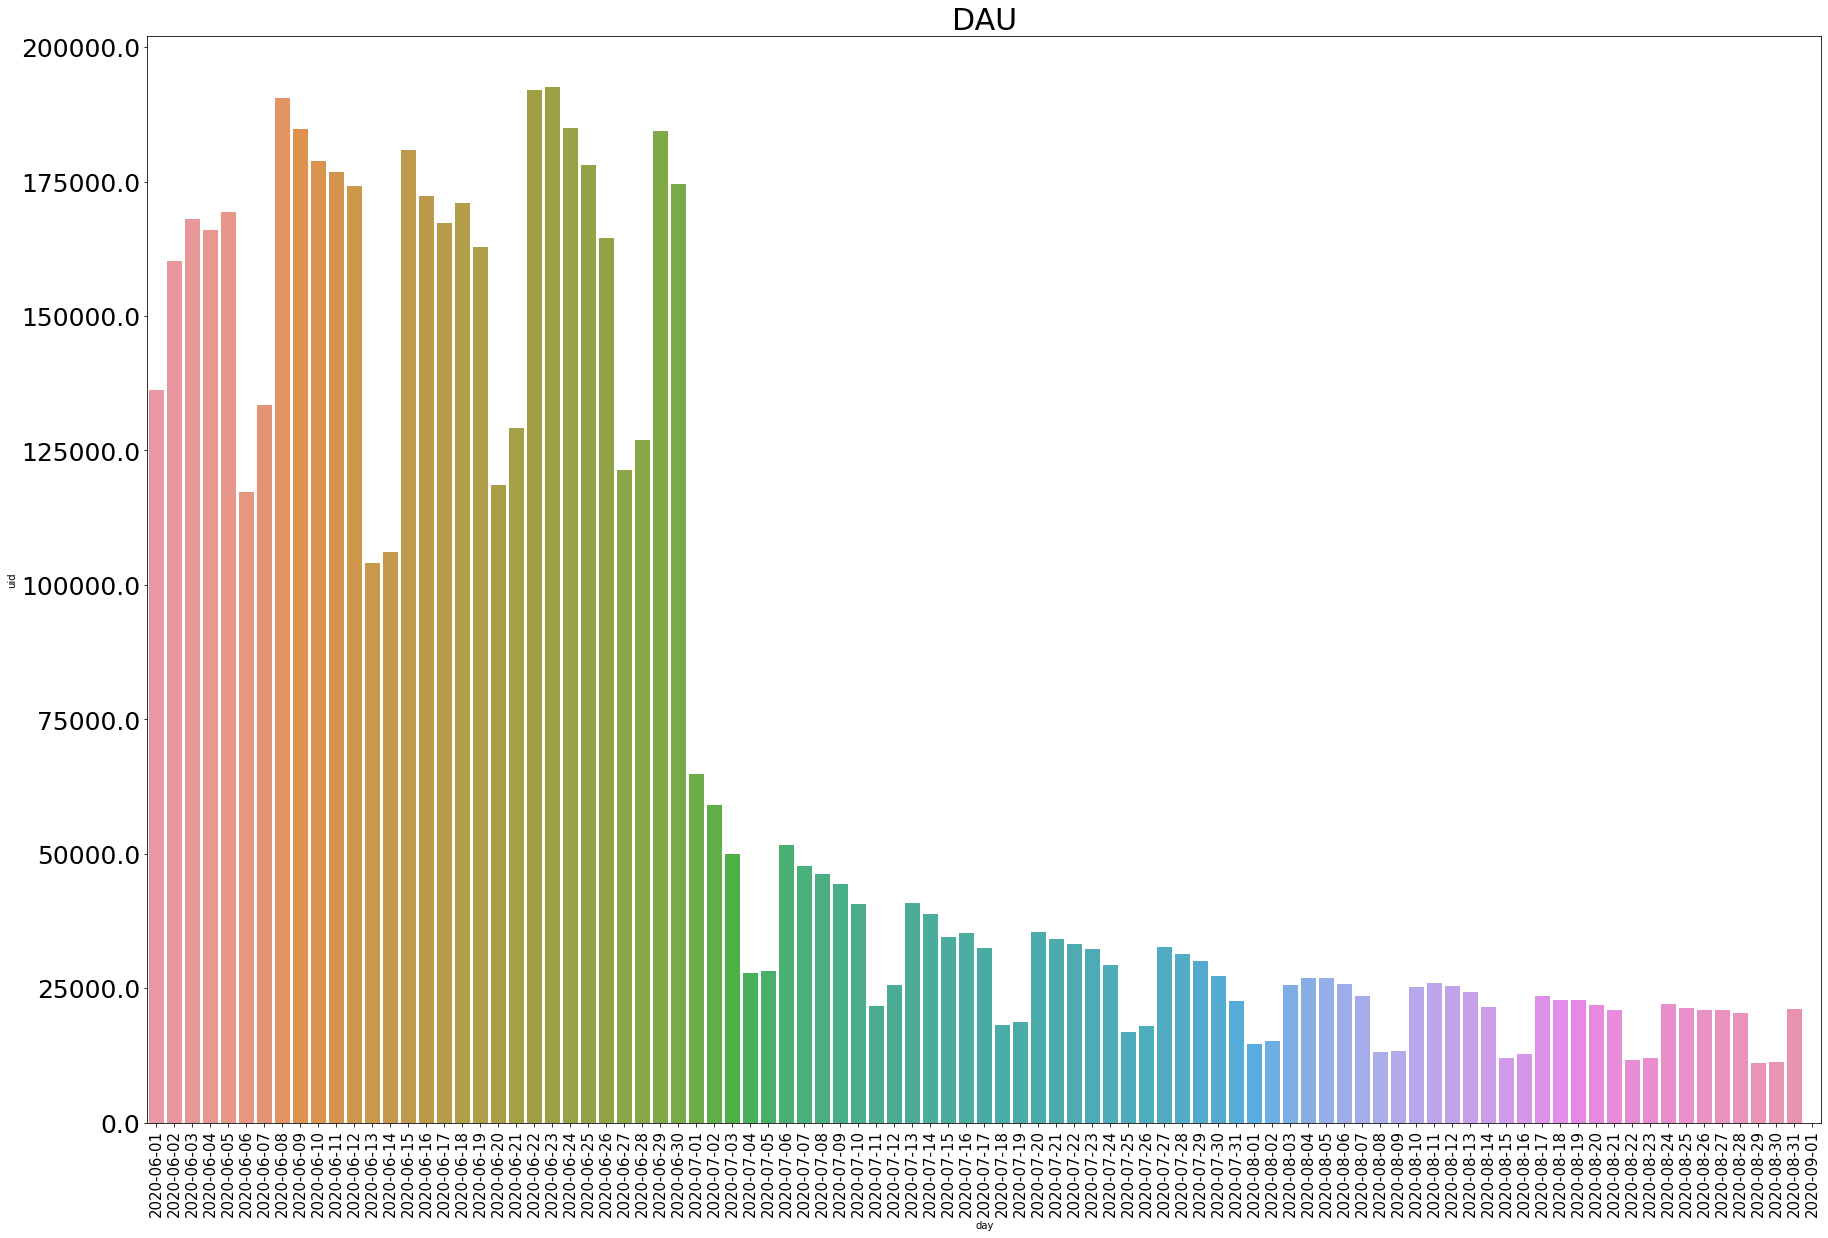

In [182]:
plt.subplots(figsize = (30,20))
ax = sns.barplot(x = 'day', y='uid', data=dau)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, size = 15)
ax.set_yticklabels(ax.get_yticks(), size = 25)
ax.set_title('DAU',size = 30)
plt.show()

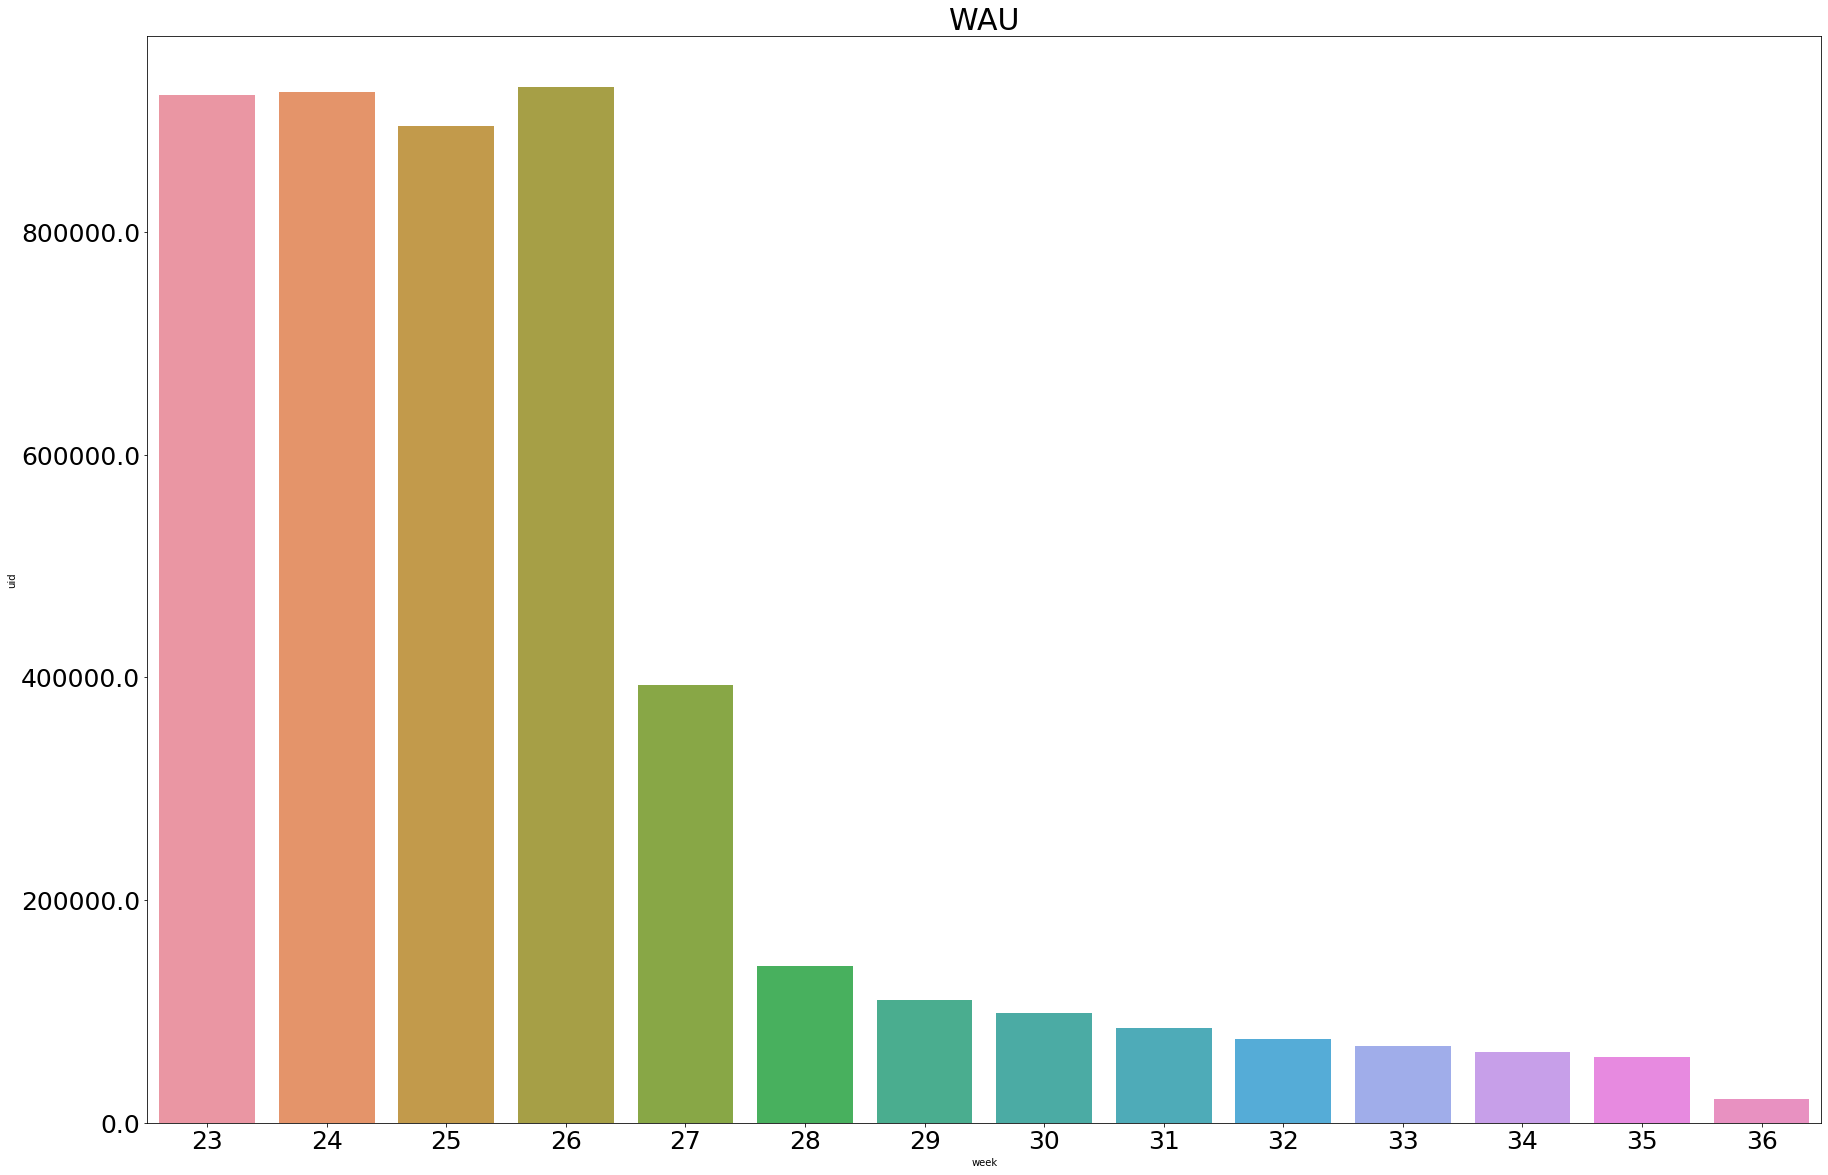

In [183]:
plt.subplots(figsize = (30,20))
ax = sns.barplot(x = 'week', y='uid', data=wau)
ax.set_xticklabels(ax.get_xticklabels(), size = 25)
ax.set_yticklabels(ax.get_yticks(), size = 25)
ax.set_title('WAU',size = 30)
plt.show()

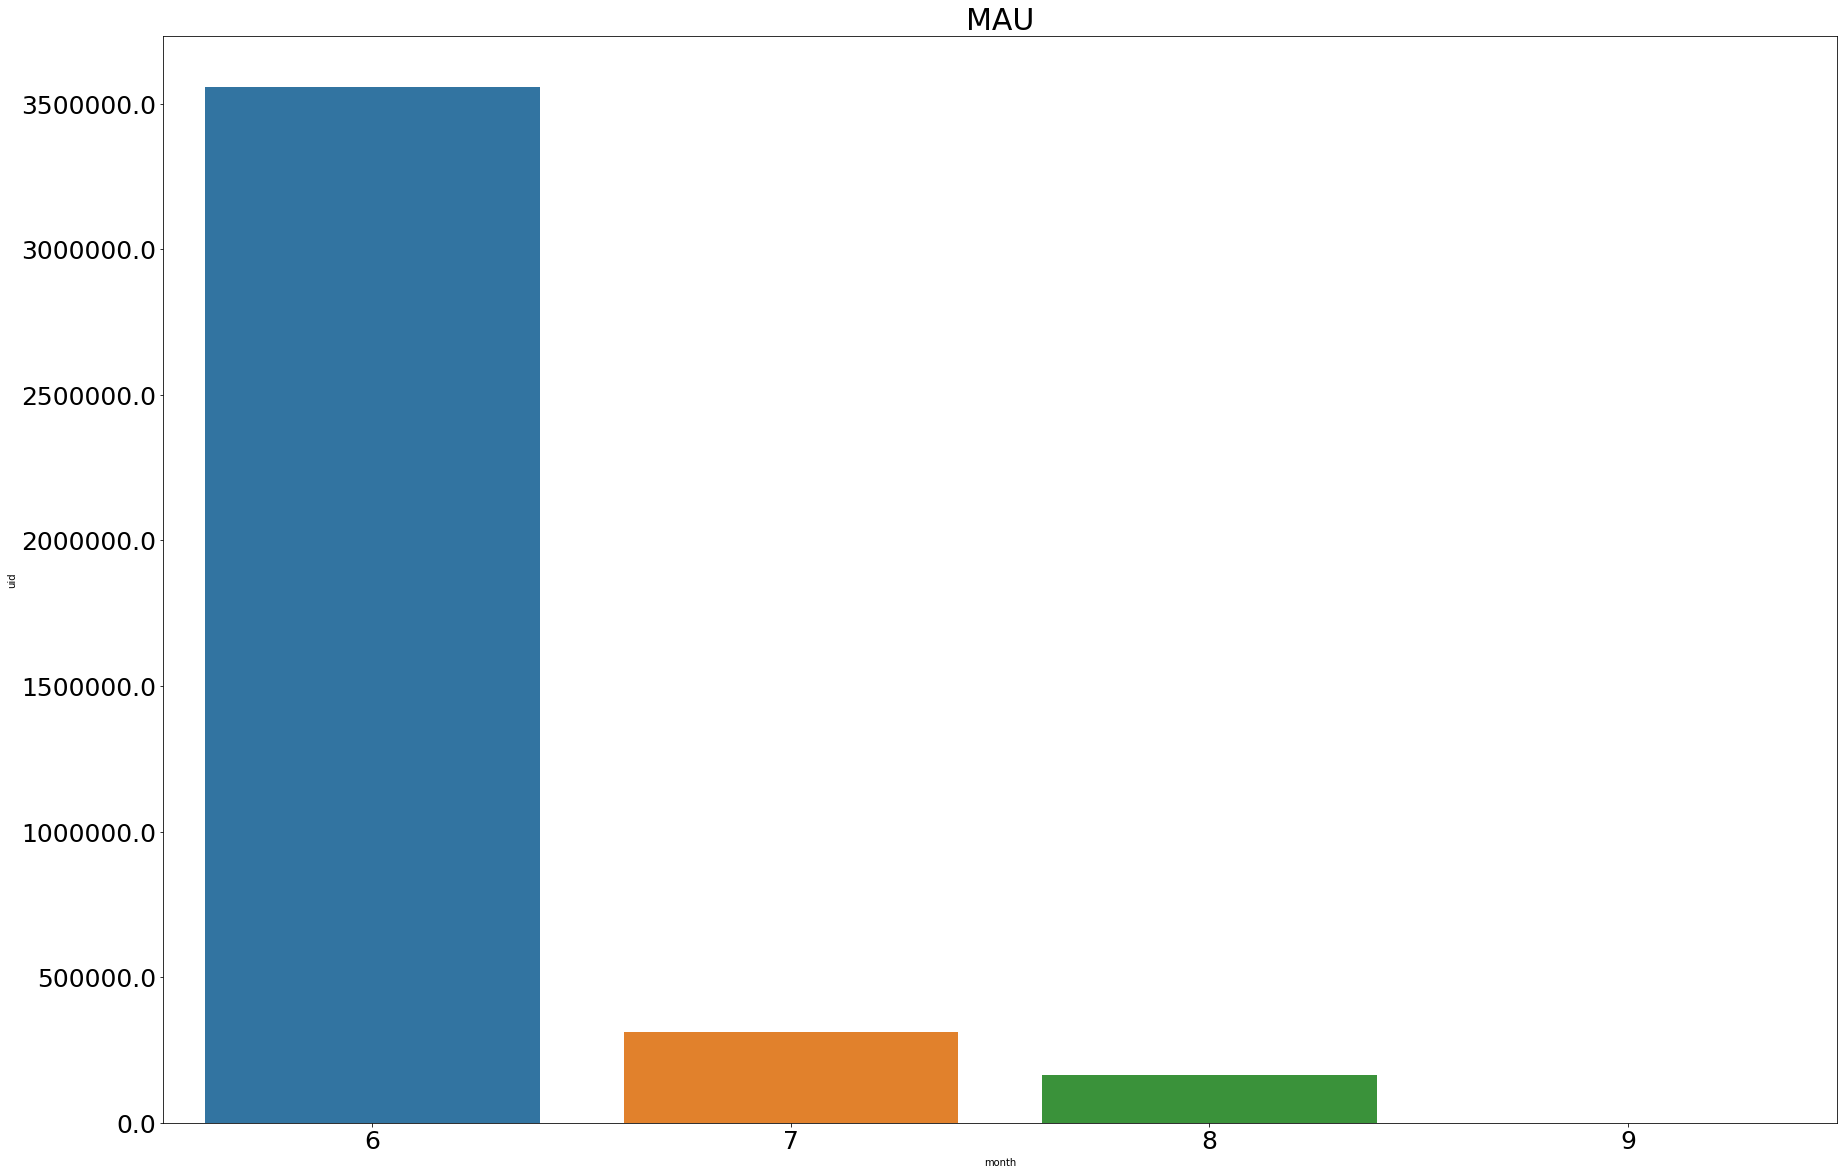

In [184]:
plt.subplots(figsize = (30,20))
ax = sns.barplot(x = 'month', y='uid', data=mau)
ax.set_xticklabels(ax.get_xticklabels(), size = 25)
ax.set_yticklabels(ax.get_yticks(), size = 25)
ax.set_title('MAU',size = 30)
plt.show()

**Stickness (коэффициент липкости)**

In [185]:
Stickness = (int(dau_total) / int(mau_total) * 100)

In [186]:
str(round(Stickness, 2))  + ' %'

'6.91 %'

In [187]:
print('Stickness = ',  str(round(Stickness, 2))  + ' %')

Stickness =  6.91 %


<div style="border:solid blue 2px; padding: 20px">
Stickness = DAU / MAU 
</div>

In [188]:
Stickness = (int(dau_total) / int(wau_total) * 100)

In [189]:
str(round(Stickness, 2))  + ' %'

'20.36 %'

In [190]:
print('Stickness = ',  str(round(Stickness, 2))  + ' %')

Stickness =  20.36 %


<div style="border:solid blue 2px; padding: 20px">
Stickness = DAU / WAU 
</div>

In [191]:
Stickness = (int(wau_total) / int(mau_total) * 100)

In [192]:
str(round(Stickness, 2))  + ' %'

'33.96 %'

In [193]:
print('Stickness = ',  str(round(Stickness, 2))  + ' %')

Stickness =  33.96 %


<div style="border:solid blue 2px; padding: 20px">
Stickness = WAU / MAU 
</div>

**Paying Share**

Paying Share - процент пользователей от всех уникальных пользователей, активных в течение периода, которые совершали платежи.

В идеале, каждый пользователь – платящий, и Paying Share равен 100%. На самом же деле этот показатель куда меньше, и его рост хотя бы на 1% – это уже большое достижение для проекта.

In [194]:
bill = df_1[df_1['event_name'] == 'billing']['uid'].nunique()

In [195]:
uid_nuniq = df_1['uid'].nunique()

In [196]:
Paying_Share = bill / uid_nuniq * 100

In [197]:
print('Paying_Share = ',  str(round(Paying_Share, 3))  + ' %')

Paying_Share =  0.004 %


<div style="border:solid blue 2px; padding: 20px">
Paying Share
</div>

**7 day Retention Rate, 30-day Retention Rate, 60-day Retention Rate**

7-day Retention - процент пользователей, которые вернулись через семь дней после первого визита.

Retention:
Retention дня X — это N% процентов пользователей, которые вернутся к продукту в день X.

In [198]:
# df_1

In [199]:
df_1['day'] = df_1['day'].astype(str)

In [207]:
df_1_d = df_1[df_1['day'] == '2020-06-01']

In [208]:
df_1_d_lst = df_1_d['uid'].to_list()
df_1_d_lst = list(set(df_1_d_lst))

In [209]:
len(df_1_d_lst)

136160

In [210]:
df_1[df_1['day'] == '2020-06-01']['uid'].nunique()

136160

**7 day Retention Rate**

In [211]:
df_7_d = df_1[df_1['day'] == '2020-06-08']

In [ ]:
df_1[df_1['day'] == '2020-06-08']['uid'].nunique()

In [212]:
nuniq_1_d_7 = df_7_d[df_7_d['uid'].isin(df_1_d_lst)]['uid'].nunique()

In [213]:
nuniq_1_d_7

4663

In [214]:
nuniq_1_d_7 / len(df_1_d_lst) * 100

3.4246474735605172

**30 day Retention Rate**

In [215]:
df_30_d = df_1[df_1['day'] == '2020-07-01']

In [216]:
df_1[df_1['day'] == '2020-07-01']['uid'].nunique()

64768

In [217]:
nuniq_1_d_30 = df_30_d[df_30_d['uid'].isin(df_1_d_lst)]['uid'].nunique()

In [218]:
nuniq_1_d_30 / len(df_1_d_lst) * 100

1.2096063454759107

**60 day Retention Rate**

In [219]:
df_60_d = df_1[df_1['day'] == '2020-07-31']

In [220]:
df_1[df_1['day'] == '2020-07-31']['uid'].nunique()

22660

In [221]:
nuniq_1_d_60 = df_60_d[df_60_d['uid'].isin(df_1_d_lst)]['uid'].nunique()

In [222]:
nuniq_1_d_60 / len(df_1_d_lst) * 100

0.5985605170387779

### рассчитаю retention rate для каждой когорты. За когорту возьму 1 неделю

In [223]:
df_1['day'] =  pd.to_datetime(df_1['day'], format='%Y-%m-%d')

In [224]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28580279 entries, 0 to 28580278
Data columns (total 32 columns):
 #   Column            Dtype         
---  ------            -----         
 0   platform          object        
 1   collector_tstamp  datetime64[ns]
 2   event_name        object        
 3   user_id           float64       
 4   domain_userid     object        
 5   page_urlpath      object        
 6   page_urlquery     object        
 7   refr_urlhost      object        
 8   refr_urlpath      object        
 9   refr_medium       object        
 10  refr_source       object        
 11  mkt_medium        object        
 12  mkt_source        object        
 13  mkt_term          object        
 14  mkt_content       object        
 15  mkt_campaign      object        
 16  pd_feature_id     object        
 17  pd_dialog_action  object        
 18  trial_product     object        
 19  trial_action      object        
 20  product_bill      object        
 21  uid   

In [225]:
first_session_dates = df_1.groupby('uid')['day'].min()

In [226]:
first_session_dates

uid
00000064-d28a-48c5-b43b-b27b1d080246   2020-06-09
000000c5-18c9-49c3-b670-5a36b5657f82   2020-06-14
00000787-0193-4b3a-a7ab-a8c04bde3e5b   2020-06-08
000010b1-ebdf-4079-bcc6-31c4fdf34ce6   2020-06-24
00001cf0-e918-461d-84e0-51094e571f58   2020-06-07
                                          ...    
ffffe5d9-030c-4e63-9096-f9fd2a3582cf   2020-06-28
ffffe6b5-fcb2-44c1-8cea-1ed58a898e3f   2020-06-10
ffffe957-5168-4da7-9e4c-9631fc5cb15c   2020-06-03
ffffeba3-9164-4e0a-93a6-f770707c00f1   2020-06-06
fffffb7e-3692-4c07-a4aa-a0d8922e37d1   2020-06-30
Name: day, Length: 3577595, dtype: datetime64[ns]

In [228]:
first_session_dates.name = 'first_session_dates'

**Объединим датафрейм `df_1` и Series `first_session_dates` по столбцу `uid`**

In [230]:
df_1.to_csv('df_1_8.csv', index = False)

In [231]:
df_8 = df_1[['uid','day','week']]

In [232]:
sessions = df_8.join(first_session_dates, on='uid')

In [233]:
sessions

,uid,day,week,first_session_dates
0,00000064-d28a-48c5-b43b-b27b1d080246,2020-06-09,24,2020-06-09
1,00000064-d28a-48c5-b43b-b27b1d080246,2020-06-09,24,2020-06-09
2,000000c5-18c9-49c3-b670-5a36b5657f82,2020-06-14,24,2020-06-14
3,000000c5-18c9-49c3-b670-5a36b5657f82,2020-06-14,24,2020-06-14
4,00000787-0193-4b3a-a7ab-a8c04bde3e5b,2020-06-08,24,2020-06-08
...,...,...,...,...
28580274,ffffe957-5168-4da7-9e4c-9631fc5cb15c,2020-06-03,23,2020-06-03
28580275,ffffeba3-9164-4e0a-93a6-f770707c00f1,2020-06-06,23,2020-06-06
28580276,ffffeba3-9164-4e0a-93a6-f770707c00f1,2020-06-06,23,2020-06-06
28580277,fffffb7e-3692-4c07-a4aa-a0d8922e37d1,2020-06-30,27,2020-06-30


In [234]:
sessions['first_session_week']  = sessions['first_session_dates'] - sessions['first_session_dates'].dt.weekday.astype('timedelta64[D]')

In [235]:
sessions['session_week_start'] = sessions['day'] - sessions['day'].dt.weekday.astype('timedelta64[D]')

Когортой станет столбец `first_session_week` — неделя, в котором была сделана первая сессия 

Отследим, как изменяется количество пользователей внутри одной когорты. Это позволит понять, сколько людей продолжают заходить в следующих месяцах после совершения первой сессии. Построим сводную таблицу.

In [237]:
sessions.pivot_table(index='first_session_week',
    columns='session_week_start',
    values='uid',
    aggfunc='nunique')

session_week_start,2020-06-01,2020-06-08,2020-06-15,2020-06-22,2020-06-29,2020-07-06,2020-07-13,2020-07-20,2020-07-27,2020-08-03,2020-08-10,2020-08-17,2020-08-24,2020-08-31
first_session_week,,,,,,,,,,,,,,
2020-06-01,922966.0,86059.0,46697.0,36480.0,28854.0,26352.0,21861.0,20168.0,17858.0,15857.0,14771.0,13477.0,12602.0,4493.0
2020-06-08,NaN,839712.0,72431.0,41744.0,30845.0,27616.0,22391.0,20490.0,17886.0,15536.0,14380.0,12834.0,11913.0,4245.0
2020-06-15,NaN,NaN,775462.0,66126.0,36412.0,30040.0,23801.0,21164.0,17921.0,15815.0,14335.0,13001.0,11863.0,4246.0
2020-06-22,NaN,NaN,NaN,785333.0,62535.0,38279.0,28333.0,24533.0,20617.0,17707.0,15935.0,14306.0,13004.0,4475.0
2020-06-29,NaN,NaN,NaN,NaN,234228.0,15792.0,10361.0,8874.0,7185.0,6185.0,5360.0,4835.0,4536.0,1610.0
2020-07-06,NaN,NaN,NaN,NaN,NaN,2774.0,648.0,520.0,450.0,389.0,383.0,359.0,358.0,170.0
2020-07-13,NaN,NaN,NaN,NaN,NaN,NaN,2468.0,557.0,433.0,375.0,352.0,315.0,293.0,140.0
2020-07-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2540.0,619.0,463.0,394.0,386.0,338.0,145.0
2020-07-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2258.0,520.0,408.0,400.0,355.0,156.0


In [238]:
sessions['cohort_lifetime_W'] = sessions['session_week_start'] - sessions['first_session_week']

In [239]:
sessions['cohort_lifetime_W'] = sessions['cohort_lifetime_W'] / np.timedelta64(1,'W')

In [240]:
sessions.cohort_lifetime_W.unique()

array([ 0., 10.,  2.,  6.,  1.,  4.,  7.,  3.,  8.,  9., 11.,  5., 12.,
       13.])

In [241]:
sessions['cohort_lifetime_W'] = sessions['cohort_lifetime_W'].round().astype('int')

In [242]:
cohorts = sessions.groupby(['first_session_week','cohort_lifetime_W']).agg({'uid':'nunique'}).reset_index()

In [243]:
cohorts

,first_session_week,cohort_lifetime_W,uid
0,2020-06-01,0,922966
1,2020-06-01,1,86059
2,2020-06-01,2,46697
3,2020-06-01,3,36480
4,2020-06-01,4,28854
...,...,...,...
100,2020-08-17,1,660
101,2020-08-17,2,221
102,2020-08-24,0,2492
103,2020-08-24,1,383


Найдём исходное количество пользователей в когорте. Возьмём их число на нулевой месяц

In [244]:
initial_users_count = cohorts[cohorts['cohort_lifetime_W'] == 0][['first_session_week','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

Объединим данные по когортам с исходным количеством пользователей в когорте

In [245]:
cohorts = cohorts.merge(initial_users_count, on='first_session_week')

In [246]:
cohorts.head()

,first_session_week,cohort_lifetime_W,uid,cohort_users
0,2020-06-01,0,922966,922966
1,2020-06-01,1,86059,922966
2,2020-06-01,2,46697,922966
3,2020-06-01,3,36480,922966
4,2020-06-01,4,28854,922966


In [247]:
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']

In [248]:
cohorts.head()

,first_session_week,cohort_lifetime_W,uid,cohort_users,retention
0,2020-06-01,0,922966,922966,1.000000
1,2020-06-01,1,86059,922966,0.093242
2,2020-06-01,2,46697,922966,0.050594
3,2020-06-01,3,36480,922966,0.039525
4,2020-06-01,4,28854,922966,0.031262


In [249]:
retention_pivot = cohorts.pivot_table(index='first_session_week',
                                                          columns='cohort_lifetime_W',
                                                          values='retention',
                                                          aggfunc='sum')

In [250]:
retention_pivot

cohort_lifetime_W,0,1,2,3,4,5,6,7,8,9,10,11,12,13
first_session_week,,,,,,,,,,,,,,
2020-06-01,1.0,0.093242,0.050594,0.039525,0.031262,0.028551,0.023686,0.021851,0.019348,0.017180,0.016004,0.014602,0.013654,0.004868
2020-06-08,1.0,0.086257,0.049712,0.036733,0.032887,0.026665,0.024401,0.021300,0.018502,0.017125,0.015284,0.014187,0.005055,NaN
2020-06-15,1.0,0.085273,0.046955,0.038738,0.030693,0.027292,0.023110,0.020394,0.018486,0.016765,0.015298,0.005475,NaN,NaN
2020-06-22,1.0,0.079629,0.048742,0.036078,0.031239,0.026253,0.022547,0.020291,0.018216,0.016559,0.005698,NaN,NaN,NaN
2020-06-29,1.0,0.067421,0.044235,0.037886,0.030675,0.026406,0.022884,0.020642,0.019366,0.006874,NaN,NaN,NaN,NaN
2020-07-06,1.0,0.233598,0.187455,0.162221,0.140231,0.138068,0.129416,0.129056,0.061283,NaN,NaN,NaN,NaN,NaN
2020-07-13,1.0,0.225689,0.175446,0.151945,0.142626,0.127634,0.118720,0.056726,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-20,1.0,0.243701,0.182283,0.155118,0.151969,0.133071,0.057087,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-27,1.0,0.230292,0.180691,0.177148,0.157219,0.069088,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:title={'center':'Retention'}, xlabel='cohort_lifetime_W', ylabel='first_session_week'>

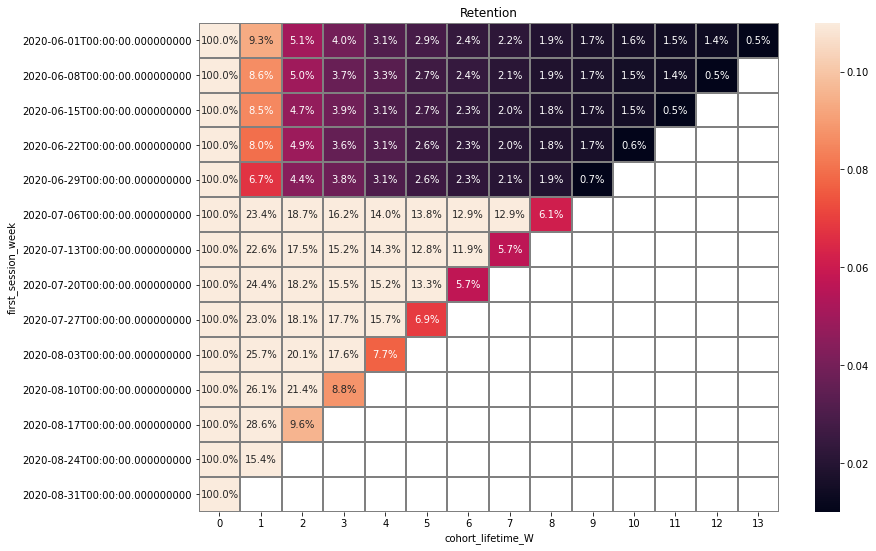

In [251]:
plt.figure(figsize=(13, 9))
plt.title('Retention')
sns.heatmap(retention_pivot, vmin=0.01, vmax=0.11, annot=True, fmt='.1%', linewidths = 1, linecolor='gray')